In [1]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Conv2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as K
import keras

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio
import sys
import csv

Using Theano backend.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [109]:
# image_path = '/home/niaki/Downloads/barbara.jpg'
# image_path = '/home/niaki/Downloads/house.tiff'
# image_path = '/home/niaki/Downloads/monarch.png'
image_path = '/home/niaki/Downloads/Lenna.png'


patch_size = 16
patch_width = patch_size
patch_height = patch_size

nearest_patches_nb = 40
query_stride = 100
compare_stride = 8
eps = 0.0001

nr_similar_patches = 40

In [110]:
image = imageio.imread(image_path)

image_height = image.shape[0]
image_width = image.shape[1]

if nearest_patches_nb == -1:
    nearest_patches_nb = len(range(0, image_width - patch_size + 1, compare_stride)) * len(range(0, image_height - patch_size + 1, compare_stride))

In [111]:
def patch_diff(patch1, patch2):
    """Computing the sum of squared differences (SSD) between two images."""
    if patch1.shape != patch2.shape:
        print("Images don't have the same shape.")
        return
    return np.sum((np.array(patch1, dtype=np.float32) - np.array(patch2, dtype=np.float32))**2)

In [112]:
# clean image

query_x_coords = []
query_y_coords = []

results_patches_diffs = {}
results_patches_x_coords = {}
results_patches_y_coords = {}
results_patches_positions = {}

counter_query_patches = 0

# just for the sake of output
total_nr_query_patches = len(range(0, image_width - patch_size + 1, query_stride)) * len(range(0, image_height - patch_size + 1, query_stride))

for y_query in range(0, image_width - patch_size + 1, query_stride):
    for x_query in range(0, image_height - patch_size + 1, query_stride):
        sys.stdout.write("\r" + str(counter_query_patches + 1) + "/" + str(total_nr_query_patches))
        
        query_x_coords.append(x_query)
        query_y_coords.append(y_query)        
    
        query_patch = image[x_query : x_query + patch_size, y_query : y_query + patch_size, :]
        
        counter_compare_patches = 0
        compare_patches_scores = {}
        
        patches_diffs = [1000000000]
        patches_x_coords = [-1]
        patches_y_coords = [-1]
        patches_positions = [-1]
        
        for y_compare in range(0, image_width - patch_size + 1, compare_stride):
            for x_compare in range(0, image_height - patch_size + 1, compare_stride):
                
                compare_patch = image[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :]
                diff = patch_diff(query_patch, compare_patch)
                
                if diff < eps:
                    counter_compare_patches += 1
                    continue
                
                # sorting
                for i in range(len(patches_diffs)):
                    if diff < patches_diffs[i]:
                        patches_diffs.insert(i, diff)
                        patches_x_coords.insert(i, x_compare)
                        patches_y_coords.insert(i, y_compare)
                        patches_positions.insert(i, counter_compare_patches)
                        break
                
                counter_compare_patches += 1
                
        results_patches_diffs[counter_query_patches] = patches_diffs[:nearest_patches_nb]
        results_patches_x_coords[counter_query_patches] = patches_x_coords[:nearest_patches_nb]
        results_patches_y_coords[counter_query_patches] = patches_y_coords[:nearest_patches_nb]
        results_patches_positions[counter_query_patches] = patches_positions[:nearest_patches_nb]
        
        counter_query_patches += 1

25/25

In [114]:
def add_gaussian_noise(image, mean=0, sigma=20):
    """Add Gaussian noise to an image of type np.uint8."""
    gaussian_noise = np.random.normal(mean, sigma, image.shape)
    gaussian_noise = gaussian_noise.reshape(image.shape)
    noisy_image = image + gaussian_noise
    noisy_image = np.clip(noisy_image, 0, 255)
    noisy_image = noisy_image.astype(np.uint8)
    return noisy_image

In [115]:
def calculate_SSDs_noisy_desc(noise_level, model_version):

    image_noisy = add_gaussian_noise(image, sigma=noise_level)
    base_dir = '/home/niaki/Code/ImageNet/tiny-imagenet-200'
    encoder = load_model(base_dir + '/encoder' + model_version + '.h5')

    print('Calculating the SSDs of noisy (noise level = ' + str(noise_level) + ') patches descriptors (desc = ' + model_version + ')...')
    
    query_x_coords = []
    query_y_coords = []

    results_noisy_descr_patches_diffs = {}
    results_noisy_descr_patches_x_coords = {}
    results_noisy_descr_patches_y_coords = {}
    results_noisy_descr_patches_positions = {}

    counter_query_patches = 0

    # just for the sake of output
    total_nr_query_patches = len(range(0, image_width - patch_size + 1, query_stride)) * len(range(0, image_height - patch_size + 1, query_stride))

    for y_query in range(0, image_width - patch_size + 1, query_stride):
        for x_query in range(0, image_height - patch_size + 1, query_stride):
            sys.stdout.write("\r" + str(counter_query_patches + 1) + "/" + str(total_nr_query_patches))

            query_x_coords.append(x_query)
            query_y_coords.append(y_query)   

            query_patch = image_noisy[x_query : x_query + patch_size, y_query : y_query + patch_size, :]
            query_patch_descr = encoder.predict(np.expand_dims(query_patch, axis=0))[0]
    #         query_patch_descr = np.mean(query_patch)

            counter_compare_patches = 0
            compare_patches_scores = {}

            patches_diffs = [1000000000]
            patches_x_coords = [-1]
            patches_y_coords = [-1]
            patches_positions = [-1]

            for y_compare in range(0, image_width - patch_size + 1, compare_stride):
                for x_compare in range(0, image_height - patch_size + 1, compare_stride):

                    compare_patch = image_noisy[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :]
                    compare_patch_descr = encoder.predict(np.expand_dims(compare_patch, axis=0))[0]
    #                 compare_patch_descr = np.mean(compare_patch)

                    diff = patch_diff(query_patch_descr, compare_patch_descr)
    #                 diff = (query_patch_descr - compare_patch_descr)**2

                    if diff < eps:
                        counter_compare_patches += 1
                        continue

                    # sorting
                    for i in range(len(patches_diffs)):
                        if diff < patches_diffs[i]:
                            patches_diffs.insert(i, diff)
                            patches_x_coords.insert(i, x_compare)
                            patches_y_coords.insert(i, y_compare)
                            patches_positions.insert(i, counter_compare_patches)
                            break

                    counter_compare_patches += 1

            results_noisy_descr_patches_diffs[counter_query_patches] = patches_diffs[:nearest_patches_nb]
            results_noisy_descr_patches_x_coords[counter_query_patches] = patches_x_coords[:nearest_patches_nb]
            results_noisy_descr_patches_y_coords[counter_query_patches] = patches_y_coords[:nearest_patches_nb]
            results_noisy_descr_patches_positions[counter_query_patches] = patches_positions[:nearest_patches_nb]

            counter_query_patches += 1
            
    print()

    print('Visualising the query and similar patches...')
    
    fig = plt.figure(figsize=(10, 20))

#     nr_similar_patches = 5

    columns = nr_similar_patches + 1
    rows = total_nr_query_patches

    counter_query_patches = 0
    for y_query in range(0, image_width - patch_size + 1, query_stride):
        for x_query in range(0, image_height - patch_size + 1, query_stride):
    #         print('query patch')

    #         print(counter_query_patches * (nr_similar_patches + 1) + 1)
            fig.add_subplot(rows, columns, counter_query_patches * (nr_similar_patches + 1) + 1)
            plt.imshow(image[x_query : x_query + patch_size, y_query : y_query + patch_size, :])

    #         print('similar patches (sorted)')

            for i in range(nr_similar_patches):
                x_compare = results_noisy_descr_patches_x_coords[counter_query_patches][i]
                y_compare = results_noisy_descr_patches_y_coords[counter_query_patches][i]

    #             print(counter_query_patches * (nr_similar_patches + 1) + 2 + i)
                fig.add_subplot(rows, columns, counter_query_patches * (nr_similar_patches + 1) + 2 + i)
                plt.imshow(image[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :])

    #         print()
            counter_query_patches += 1


    print('Calculating SSDs of the ground truth patches...')
    
    ssds = []

#     nr_similar_patches = 20

    for q_it in range(total_nr_query_patches):
        for c_it in range(nr_similar_patches):

            # getting the query patch from the clean image
            x_query = query_x_coords[q_it]
            y_query = query_y_coords[q_it]
            query_patch = image[x_query : x_query + patch_size, y_query : y_query + patch_size, :]

            # getting the compare patch from the clean image
            x_compare = results_noisy_descr_patches_x_coords[q_it][c_it]
            y_compare = results_noisy_descr_patches_y_coords[q_it][c_it]
            compare_patch = image[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :]

            # calculating the difference in the clean image
            actual_diff = patch_diff(query_patch, compare_patch)
            ssds.append(actual_diff)

    ssds = np.array(ssds)
    
    print('Plotting the graph of the SSDs of grount truth patches...')
    
    plt.figure(figsize=(10, 5))
    plt.hist(ssds, 50, normed=1)
    plt.xlim(0, 15000000)
    plt.show()
    
    return ssds

In [87]:
def calculate_SSDs_noisy_desc_no_output(noise_level, model_version):

    image_noisy = add_gaussian_noise(image, sigma=noise_level)
    base_dir = '/home/niaki/Code/ImageNet/tiny-imagenet-200'
    encoder = load_model(base_dir + '/encoder' + model_version + '.h5')

    query_x_coords = []
    query_y_coords = []

    results_noisy_descr_patches_diffs = {}
    results_noisy_descr_patches_x_coords = {}
    results_noisy_descr_patches_y_coords = {}
    results_noisy_descr_patches_positions = {}

    counter_query_patches = 0

    # just for the sake of output
    total_nr_query_patches = len(range(0, image_width - patch_size + 1, query_stride)) * len(range(0, image_height - patch_size + 1, query_stride))

    for y_query in range(0, image_width - patch_size + 1, query_stride):
        for x_query in range(0, image_height - patch_size + 1, query_stride):
#             sys.stdout.write("\r" + str(counter_query_patches + 1) + "/" + str(total_nr_query_patches))

            query_x_coords.append(x_query)
            query_y_coords.append(y_query)   

            query_patch = image_noisy[x_query : x_query + patch_size, y_query : y_query + patch_size, :]
            query_patch_descr = encoder.predict(np.expand_dims(query_patch, axis=0))[0]
    #         query_patch_descr = np.mean(query_patch)

            counter_compare_patches = 0
            compare_patches_scores = {}

            patches_diffs = [1000000000]
            patches_x_coords = [-1]
            patches_y_coords = [-1]
            patches_positions = [-1]

            for y_compare in range(0, image_width - patch_size + 1, compare_stride):
                for x_compare in range(0, image_height - patch_size + 1, compare_stride):

                    compare_patch = image_noisy[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :]
                    compare_patch_descr = encoder.predict(np.expand_dims(compare_patch, axis=0))[0]
    #                 compare_patch_descr = np.mean(compare_patch)

                    diff = patch_diff(query_patch_descr, compare_patch_descr)
    #                 diff = (query_patch_descr - compare_patch_descr)**2

                    if diff < eps:
                        counter_compare_patches += 1
                        continue

                    # sorting
                    for i in range(len(patches_diffs)):
                        if diff < patches_diffs[i]:
                            patches_diffs.insert(i, diff)
                            patches_x_coords.insert(i, x_compare)
                            patches_y_coords.insert(i, y_compare)
                            patches_positions.insert(i, counter_compare_patches)
                            break

                    counter_compare_patches += 1

            results_noisy_descr_patches_diffs[counter_query_patches] = patches_diffs[:nearest_patches_nb]
            results_noisy_descr_patches_x_coords[counter_query_patches] = patches_x_coords[:nearest_patches_nb]
            results_noisy_descr_patches_y_coords[counter_query_patches] = patches_y_coords[:nearest_patches_nb]
            results_noisy_descr_patches_positions[counter_query_patches] = patches_positions[:nearest_patches_nb]

            counter_query_patches += 1
            
    
        
    ssds = []

#     nr_similar_patches = 1000

    for q_it in range(total_nr_query_patches):
        for c_it in range(nr_similar_patches):

            # getting the query patch from the clean image
            x_query = query_x_coords[q_it]
            y_query = query_y_coords[q_it]
            query_patch = image[x_query : x_query + patch_size, y_query : y_query + patch_size, :]

            # getting the compare patch from the clean image
            x_compare = results_noisy_descr_patches_x_coords[q_it][c_it]
            y_compare = results_noisy_descr_patches_y_coords[q_it][c_it]
            compare_patch = image[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :]

            # calculating the difference in the clean image
            actual_diff = patch_diff(query_patch, compare_patch)
            ssds.append(actual_diff)

    ssds = np.array(ssds)
    
    
    return ssds

***** Evaluating model 16_3conv3mp_2.7 *****
--- Noise level 0 ---
Calculating the SSDs of noisy (noise level = 0) patches descriptors (desc = 16_3conv3mp_2.7)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


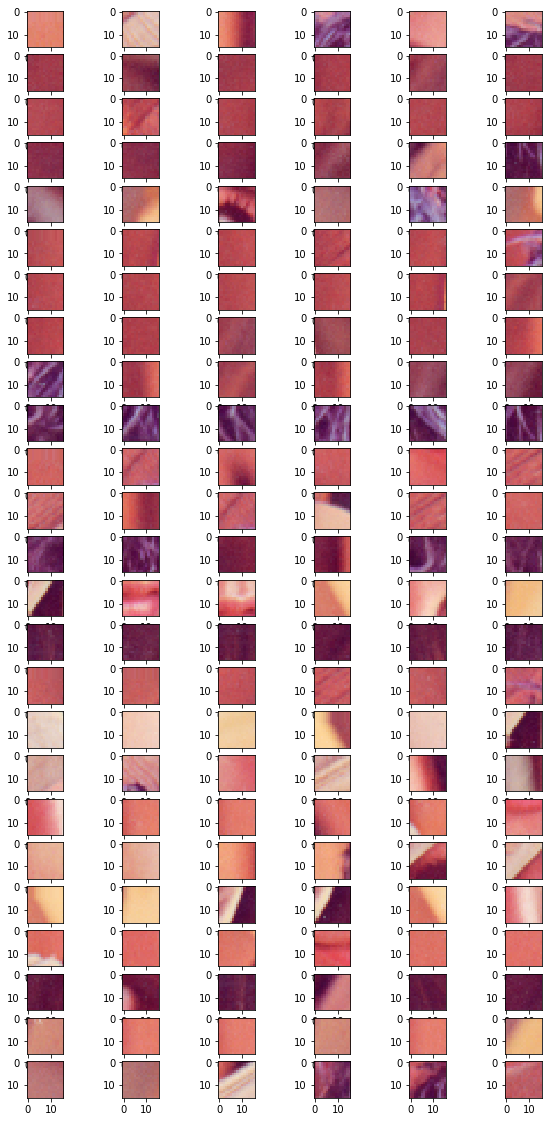

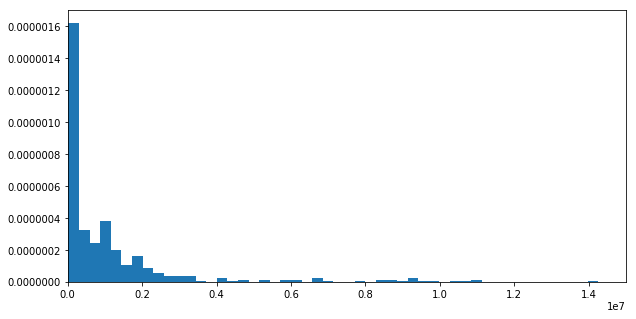

Model 16_3conv3mp_2.7 noise = 00 -- mean 1140909.6 -- std 1956398.2
--- Noise level 10 ---
Calculating the SSDs of noisy (noise level = 10) patches descriptors (desc = 16_3conv3mp_2.7)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


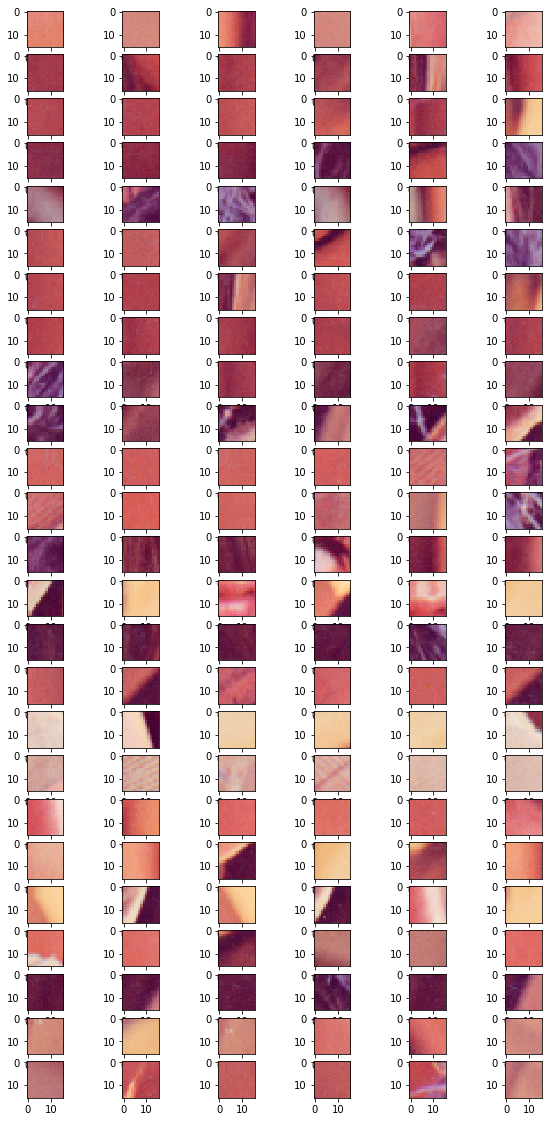

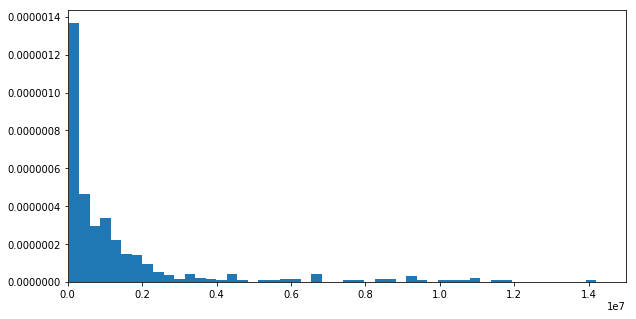

Model 16_3conv3mp_2.7 noise = 10 -- mean 1302397.8 -- std 2153123.0
--- Noise level 20 ---
Calculating the SSDs of noisy (noise level = 20) patches descriptors (desc = 16_3conv3mp_2.7)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


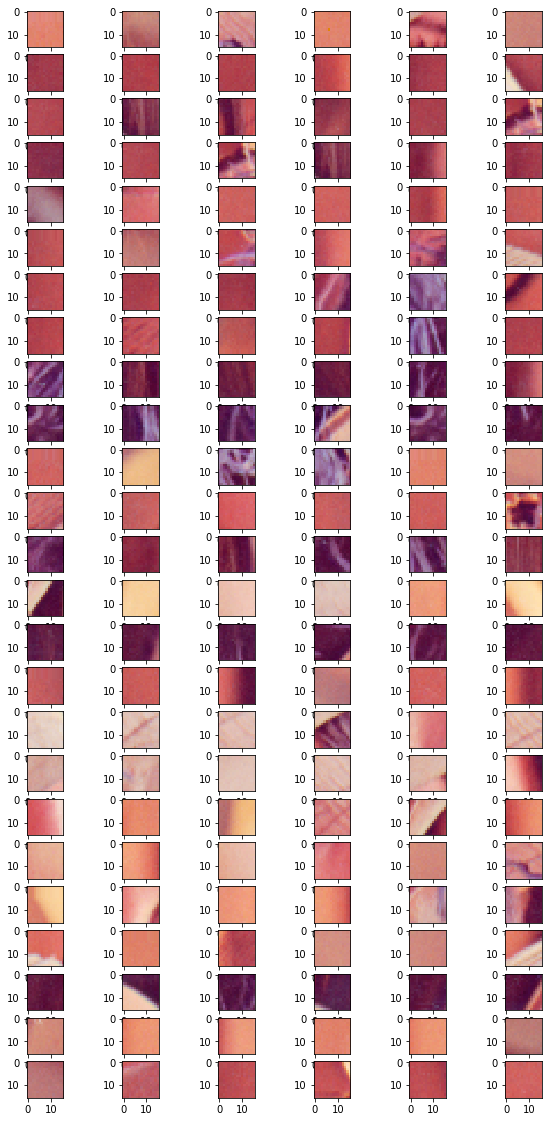

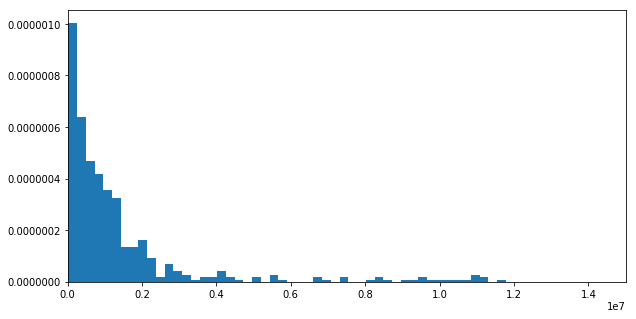

Model 16_3conv3mp_2.7 noise = 20 -- mean 1378573.5 -- std 2070715.0
--- Noise level 30 ---
Calculating the SSDs of noisy (noise level = 30) patches descriptors (desc = 16_3conv3mp_2.7)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


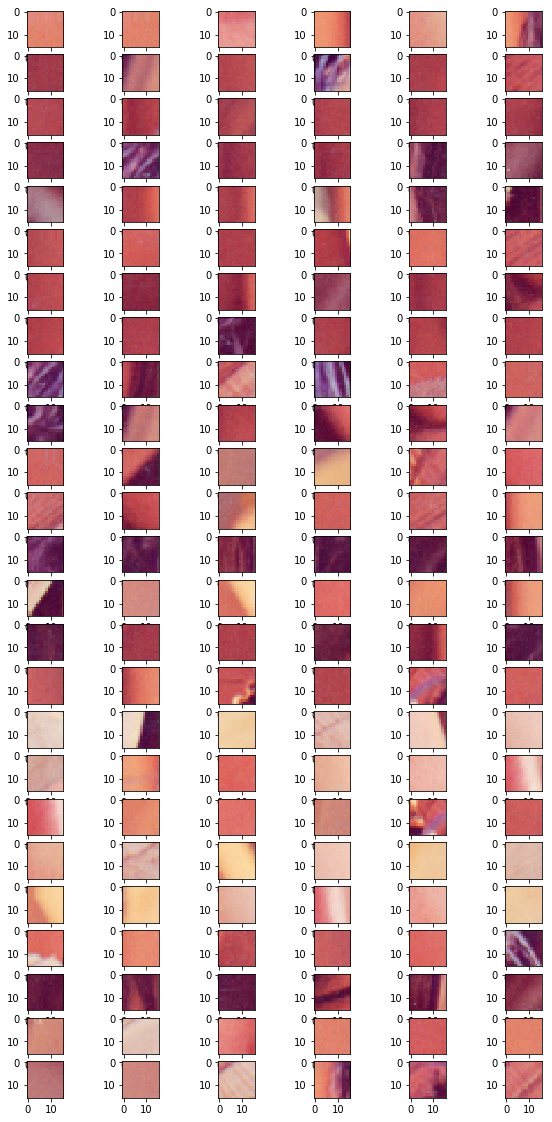

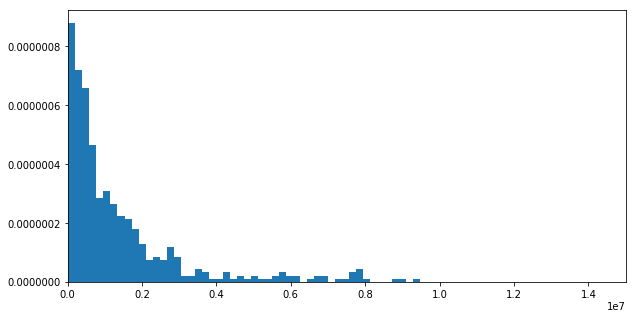

Model 16_3conv3mp_2.7 noise = 30 -- mean 1374609.4 -- std 1708311.0
--- Noise level 40 ---
Calculating the SSDs of noisy (noise level = 40) patches descriptors (desc = 16_3conv3mp_2.7)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


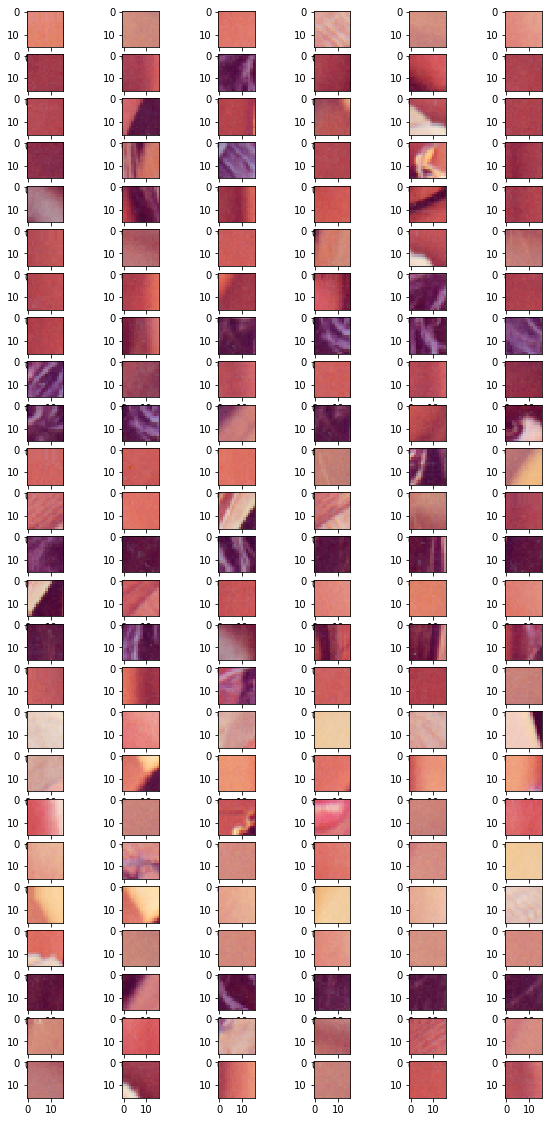

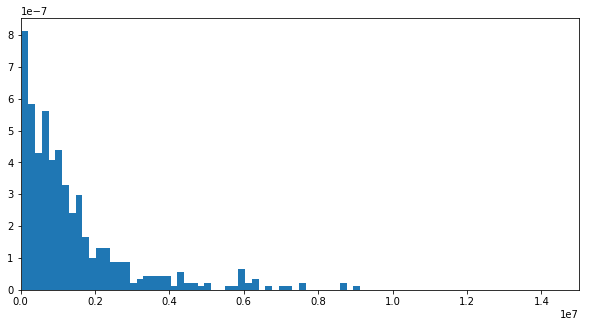

Model 16_3conv3mp_2.7 noise = 40 -- mean 1384202.5 -- std 1525685.2
--- Noise level 50 ---
Calculating the SSDs of noisy (noise level = 50) patches descriptors (desc = 16_3conv3mp_2.7)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


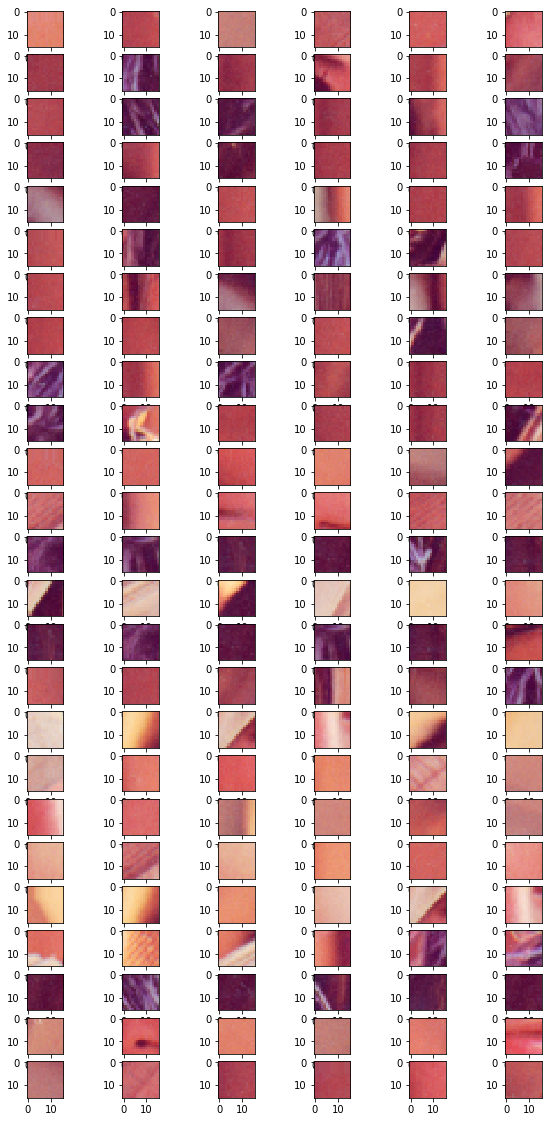

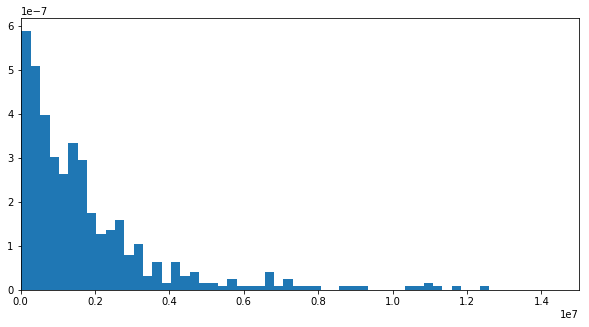

Model 16_3conv3mp_2.7 noise = 50 -- mean 1756653.6 -- std 1972500.9
***** Evaluating model 16_3conv3mp_4.0 *****
--- Noise level 0 ---


/home/niaki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/utils/conv_utils.py:82: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


Calculating the SSDs of noisy (noise level = 0) patches descriptors (desc = 16_3conv3mp_4.0)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


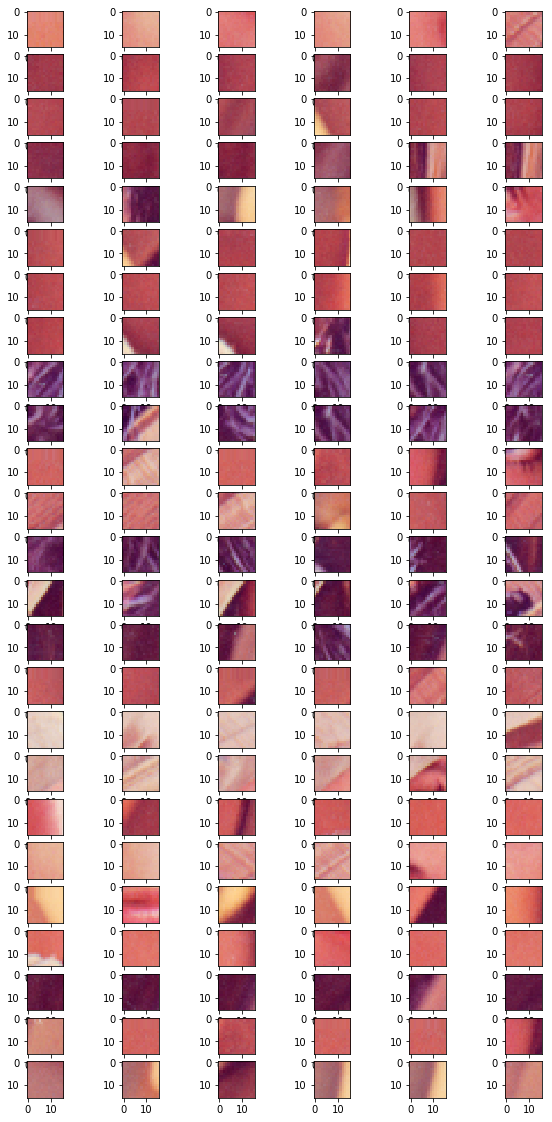

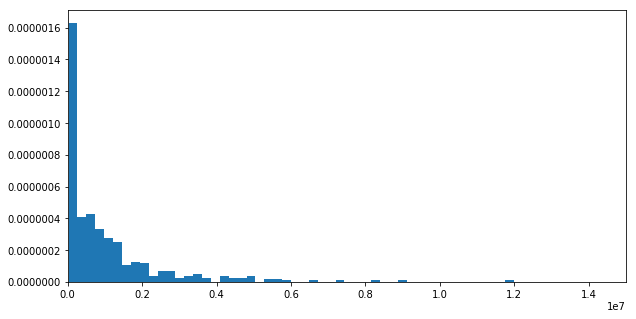

Model 16_3conv3mp_4.0 noise = 00 -- mean 997367.44 -- std 1383109.4
--- Noise level 10 ---
Calculating the SSDs of noisy (noise level = 10) patches descriptors (desc = 16_3conv3mp_4.0)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


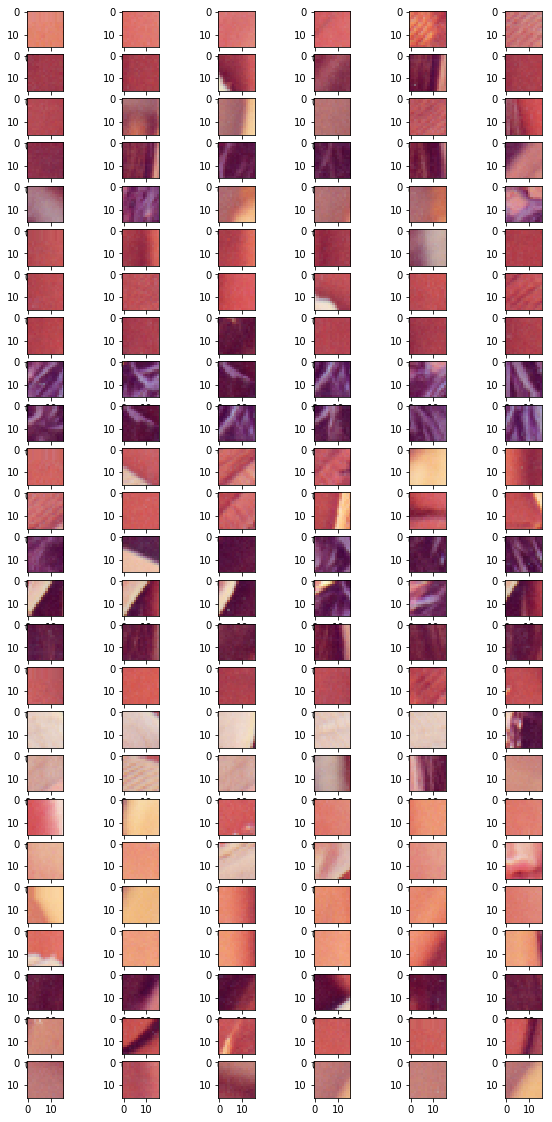

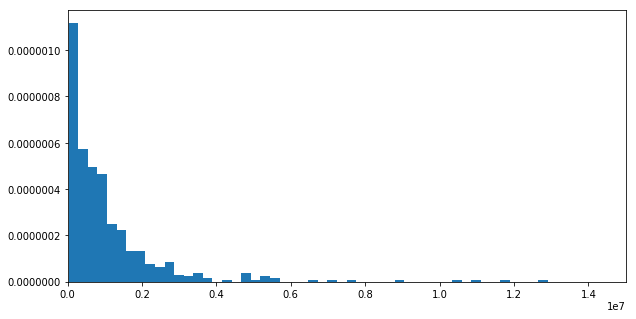

Model 16_3conv3mp_4.0 noise = 10 -- mean 1088691.8 -- std 1504601.0
--- Noise level 20 ---
Calculating the SSDs of noisy (noise level = 20) patches descriptors (desc = 16_3conv3mp_4.0)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


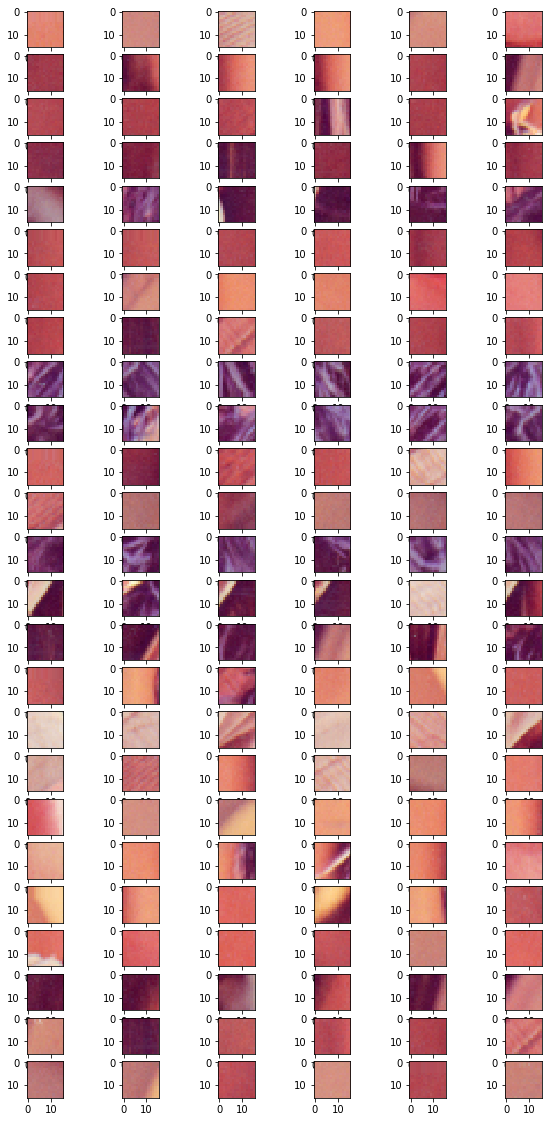

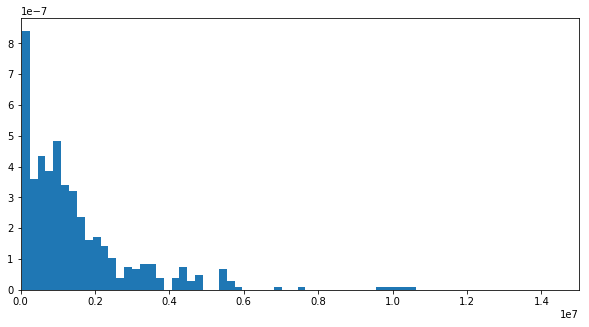

Model 16_3conv3mp_4.0 noise = 20 -- mean 1476068.4 -- std 1573618.2
--- Noise level 30 ---
Calculating the SSDs of noisy (noise level = 30) patches descriptors (desc = 16_3conv3mp_4.0)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


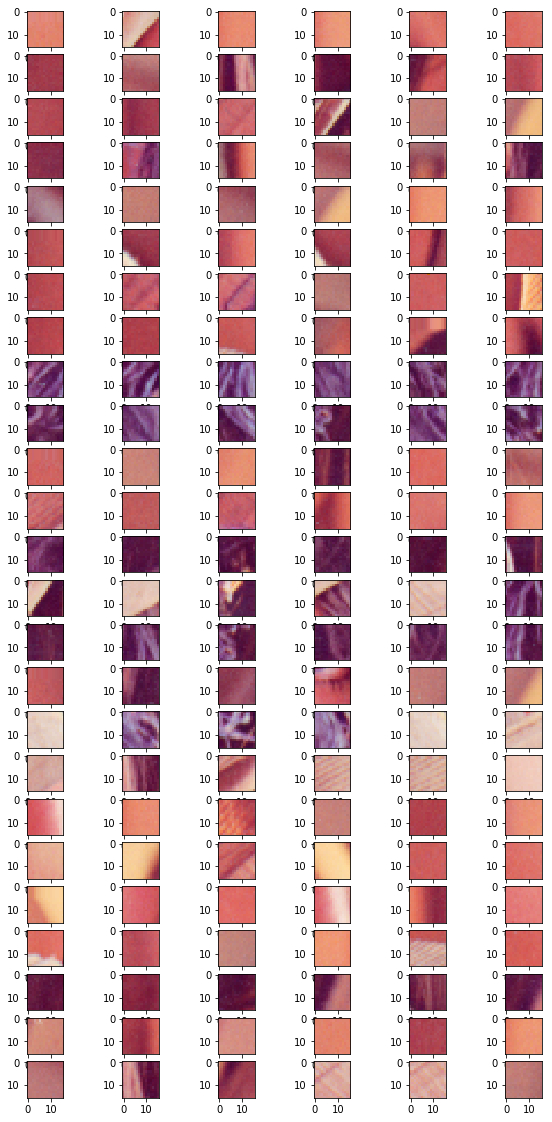

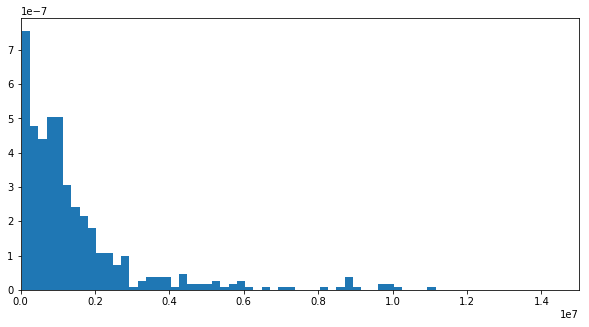

Model 16_3conv3mp_4.0 noise = 30 -- mean 1477111.0 -- std 1803585.9
--- Noise level 40 ---
Calculating the SSDs of noisy (noise level = 40) patches descriptors (desc = 16_3conv3mp_4.0)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


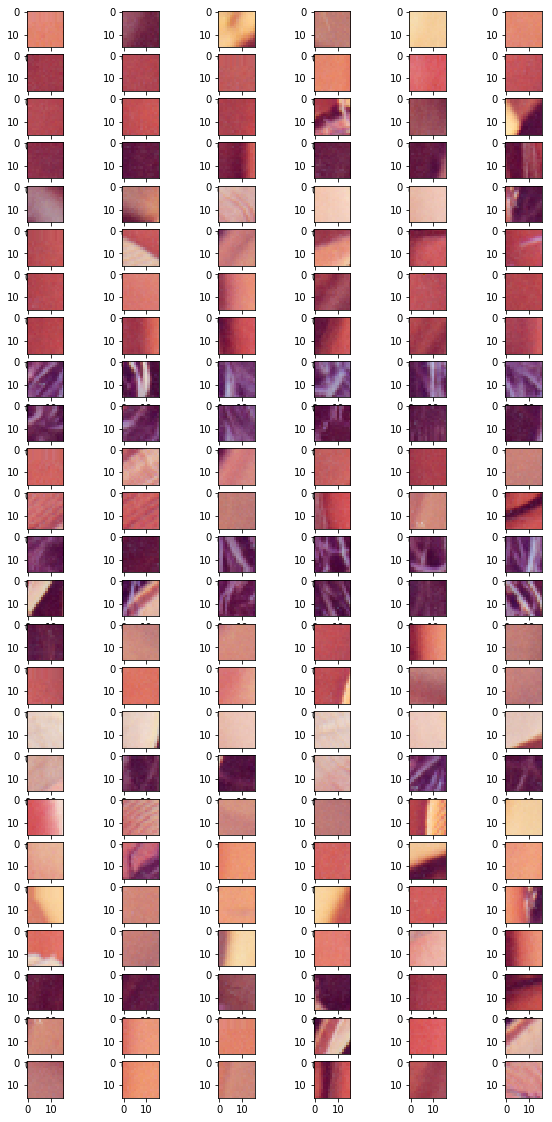

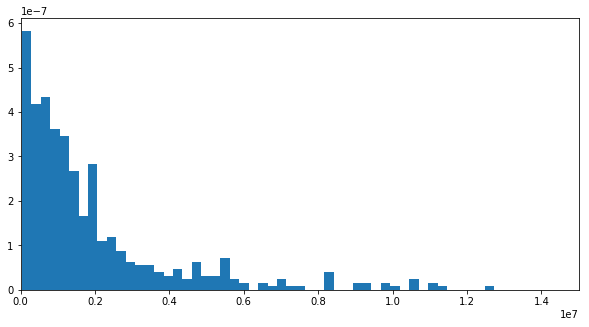

Model 16_3conv3mp_4.0 noise = 40 -- mean 1913011.5 -- std 2190826.5
--- Noise level 50 ---
Calculating the SSDs of noisy (noise level = 50) patches descriptors (desc = 16_3conv3mp_4.0)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


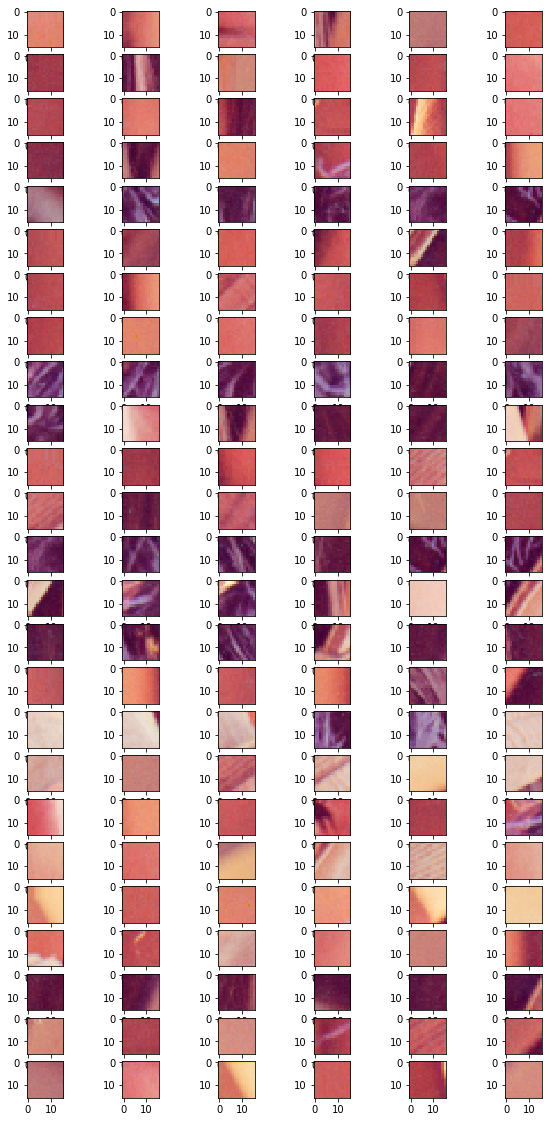

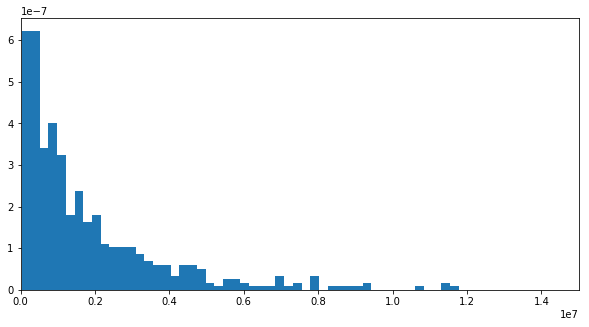

Model 16_3conv3mp_4.0 noise = 50 -- mean 1818056.5 -- std 2014015.1
***** Evaluating model 16_3conv3mp_4.1 *****
--- Noise level 0 ---
Calculating the SSDs of noisy (noise level = 0) patches descriptors (desc = 16_3conv3mp_4.1)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


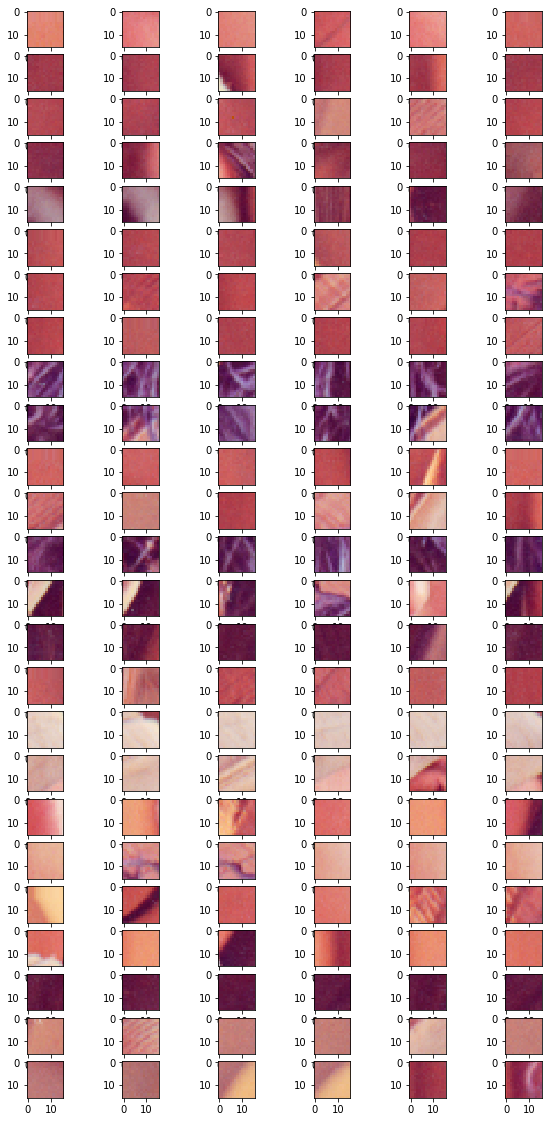

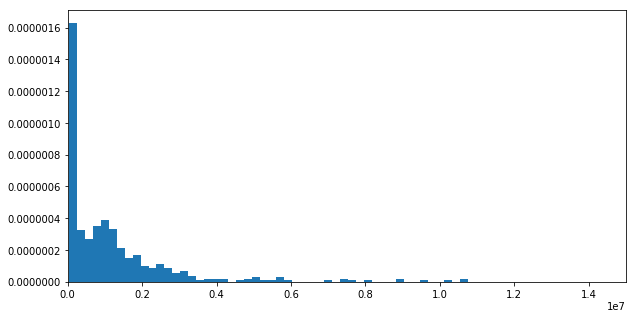

Model 16_3conv3mp_4.1 noise = 00 -- mean 1179964.1 -- std 1610148.9
--- Noise level 10 ---
Calculating the SSDs of noisy (noise level = 10) patches descriptors (desc = 16_3conv3mp_4.1)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


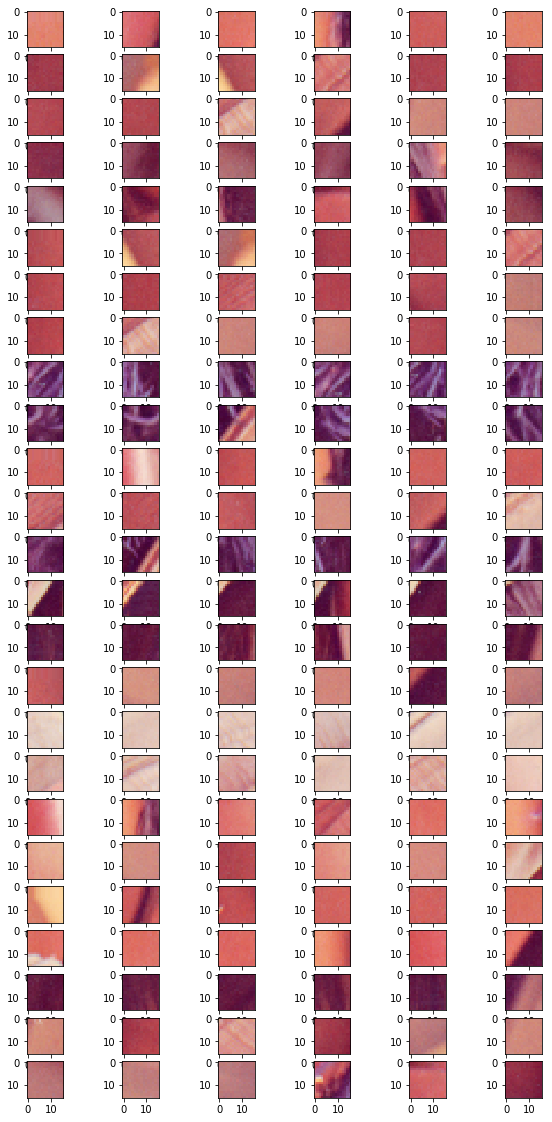

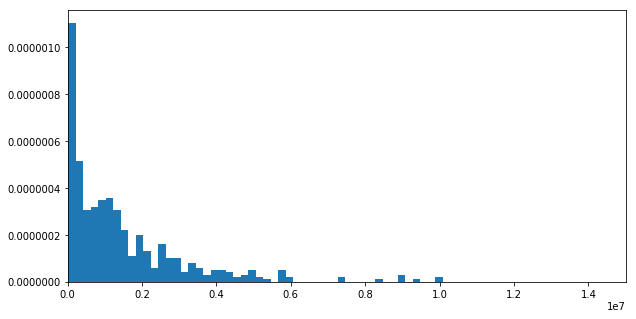

Model 16_3conv3mp_4.1 noise = 10 -- mean 1455735.0 -- std 1653472.5
--- Noise level 20 ---
Calculating the SSDs of noisy (noise level = 20) patches descriptors (desc = 16_3conv3mp_4.1)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


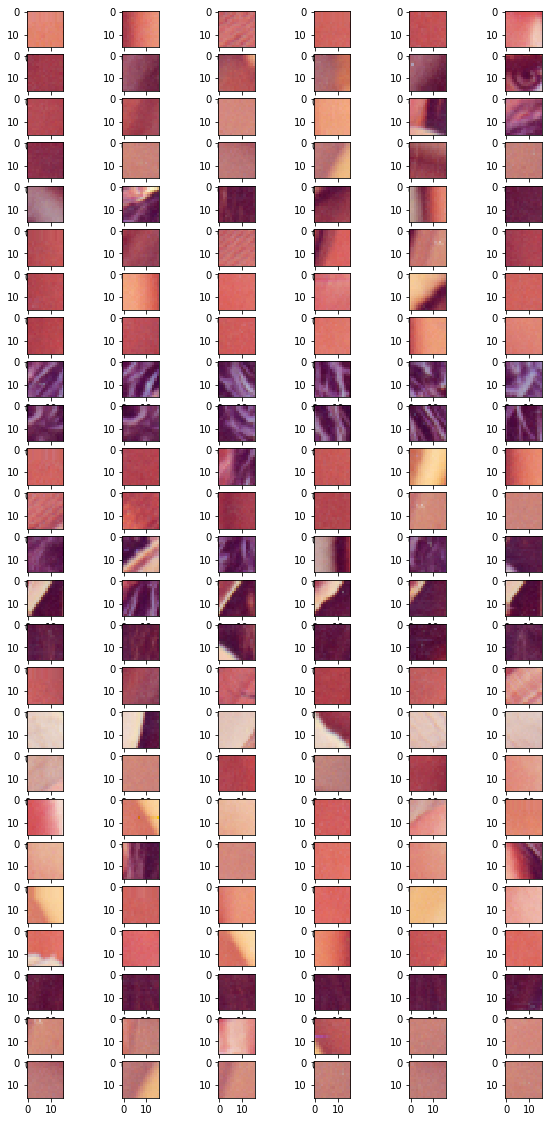

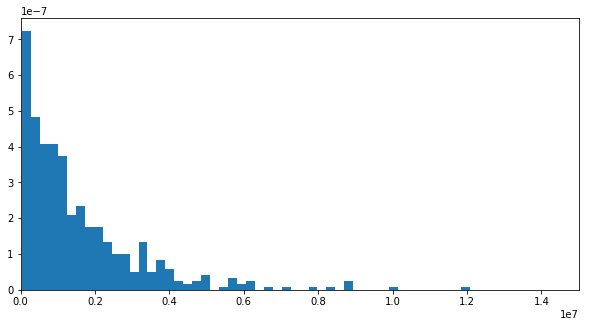

Model 16_3conv3mp_4.1 noise = 20 -- mean 1561618.0 -- std 1642531.6
--- Noise level 30 ---
Calculating the SSDs of noisy (noise level = 30) patches descriptors (desc = 16_3conv3mp_4.1)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


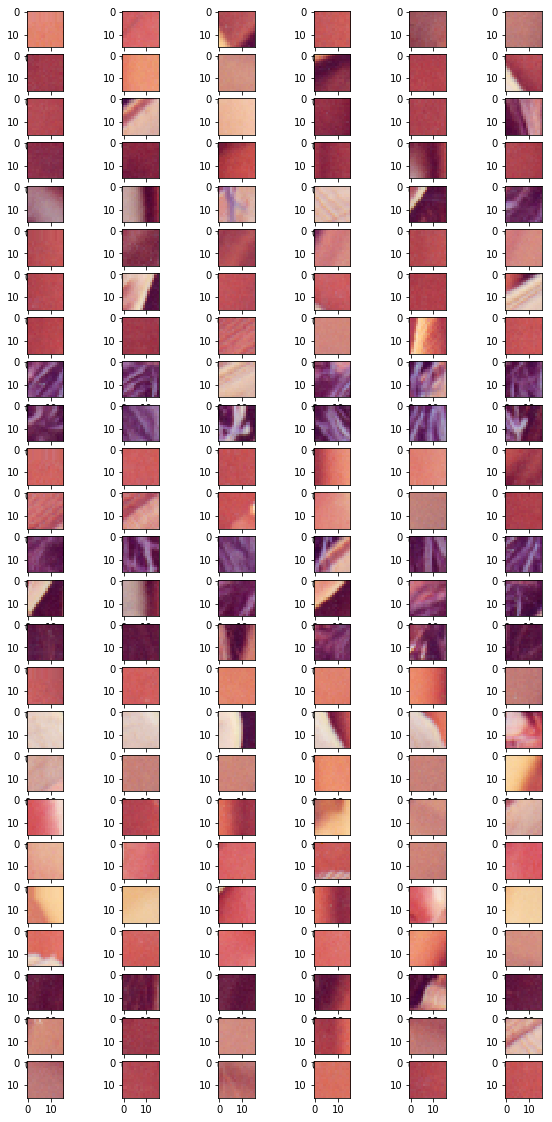

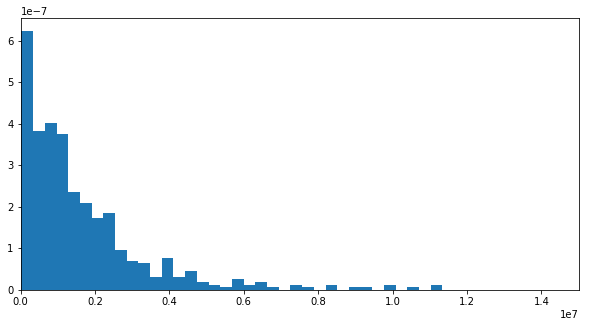

Model 16_3conv3mp_4.1 noise = 30 -- mean 1683646.5 -- std 1897820.4
--- Noise level 40 ---
Calculating the SSDs of noisy (noise level = 40) patches descriptors (desc = 16_3conv3mp_4.1)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


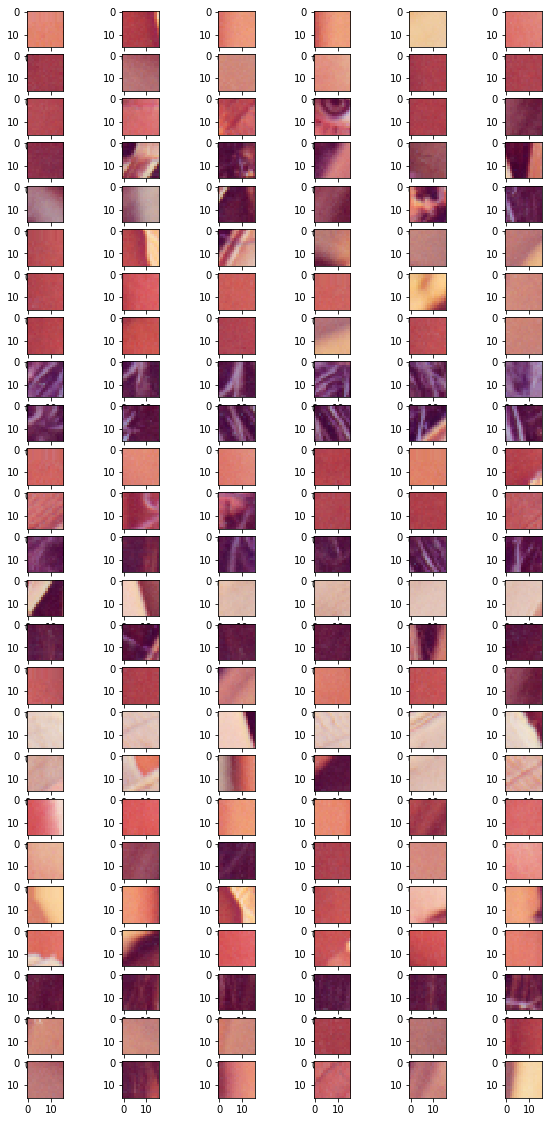

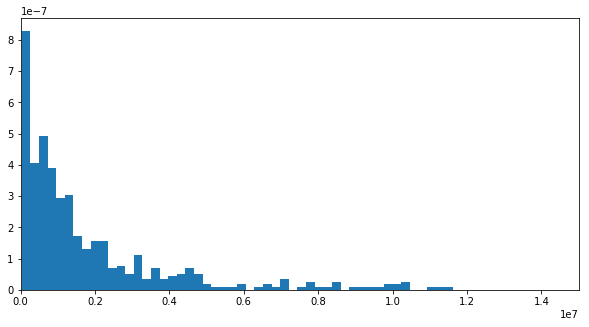

Model 16_3conv3mp_4.1 noise = 40 -- mean 1796433.6 -- std 2206253.0
--- Noise level 50 ---
Calculating the SSDs of noisy (noise level = 50) patches descriptors (desc = 16_3conv3mp_4.1)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


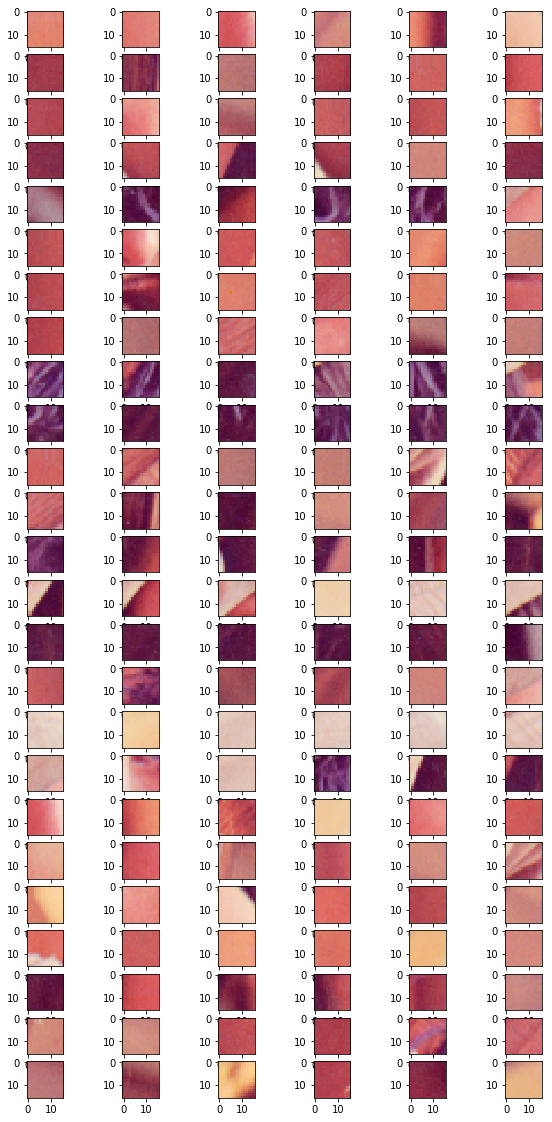

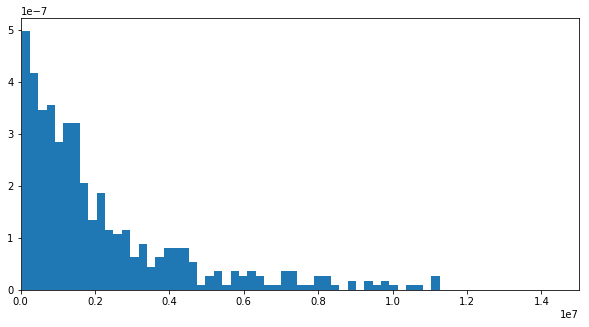

Model 16_3conv3mp_4.1 noise = 50 -- mean 2139341.8 -- std 2246270.8
***** Evaluating model 16_3conv3mp_4.2_sigmoid *****
--- Noise level 0 ---
Calculating the SSDs of noisy (noise level = 0) patches descriptors (desc = 16_3conv3mp_4.2_sigmoid)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


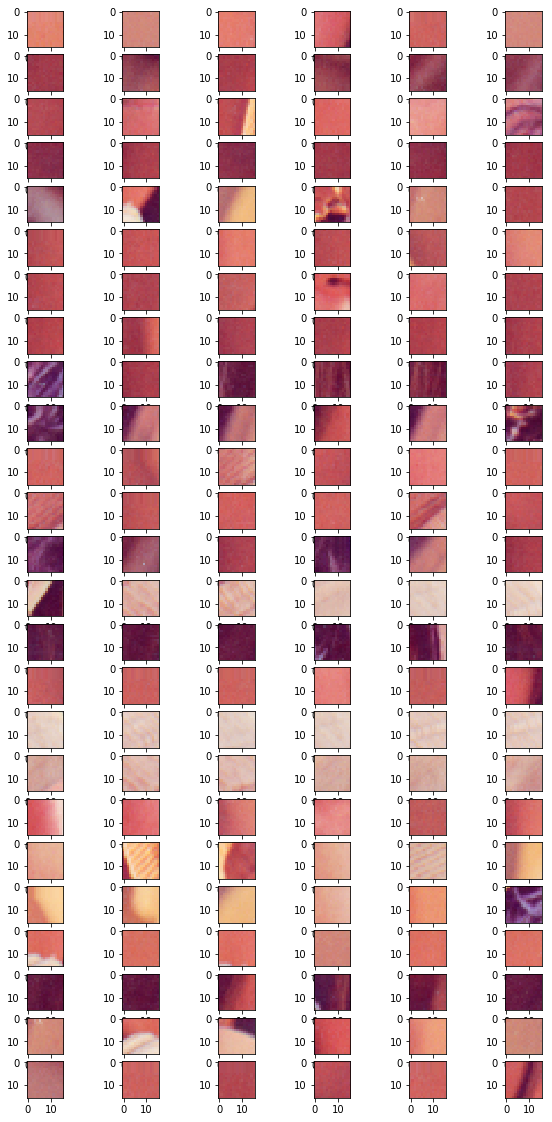

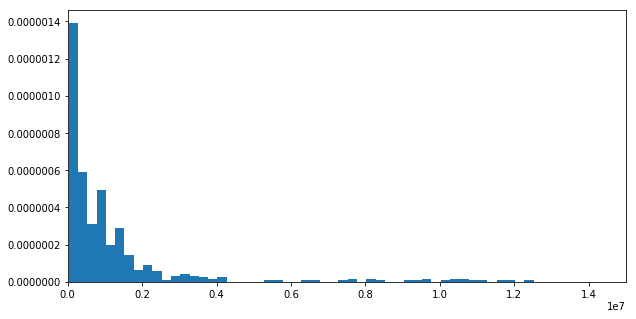

Model 16_3conv3mp_4.2_sigmoid noise = 00 -- mean 1177173.2 -- std 2012979.2
--- Noise level 10 ---
Calculating the SSDs of noisy (noise level = 10) patches descriptors (desc = 16_3conv3mp_4.2_sigmoid)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


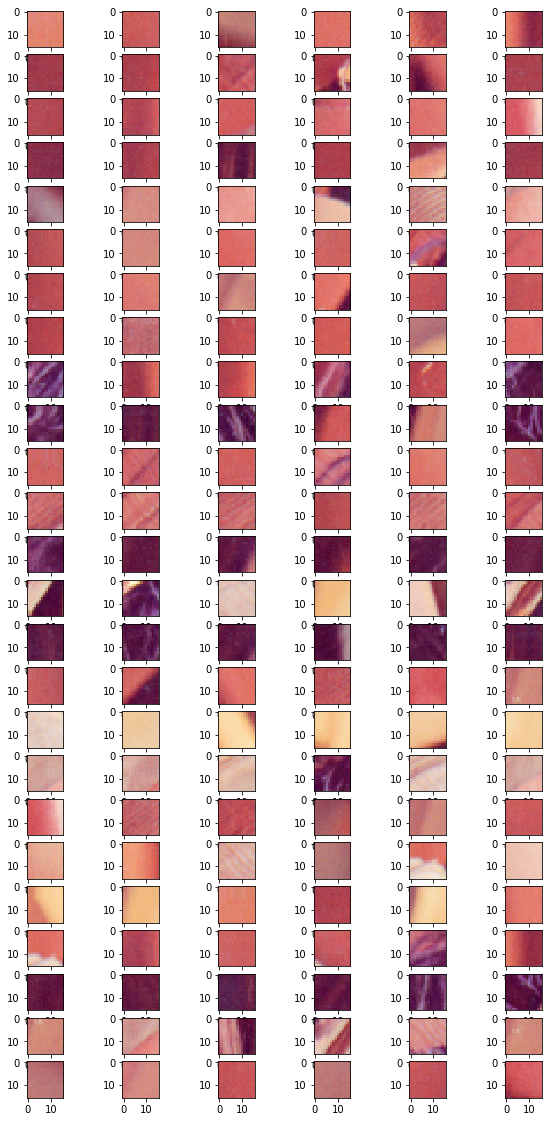

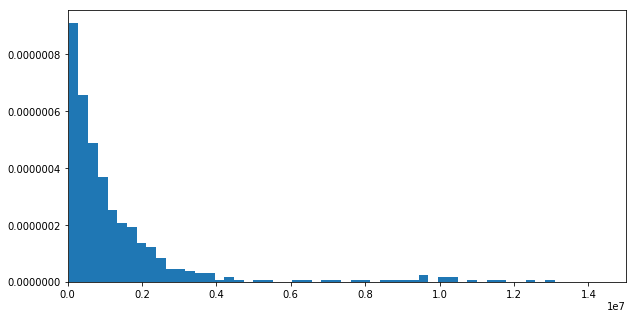

Model 16_3conv3mp_4.2_sigmoid noise = 10 -- mean 1358751.5 -- std 1994785.9
--- Noise level 20 ---
Calculating the SSDs of noisy (noise level = 20) patches descriptors (desc = 16_3conv3mp_4.2_sigmoid)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


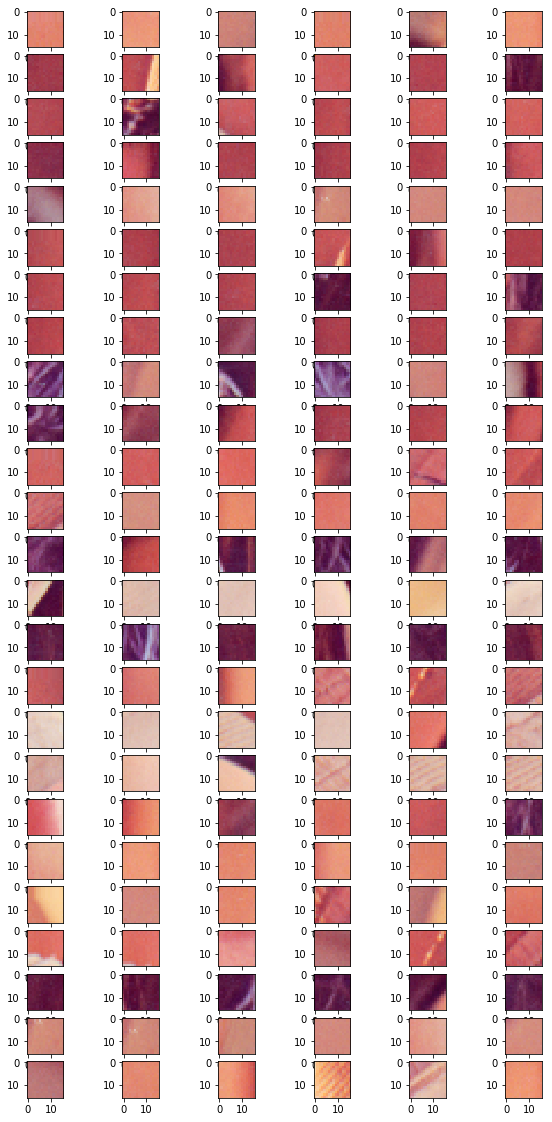

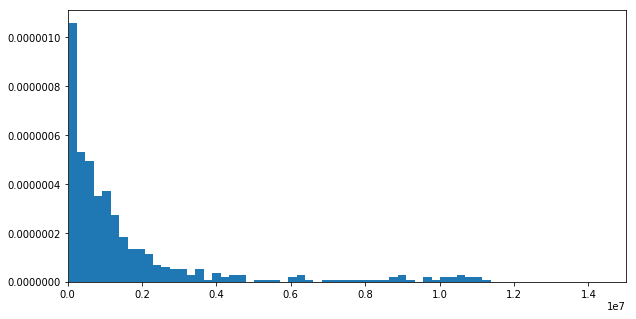

Model 16_3conv3mp_4.2_sigmoid noise = 20 -- mean 1571759.8 -- std 2288283.2
--- Noise level 30 ---
Calculating the SSDs of noisy (noise level = 30) patches descriptors (desc = 16_3conv3mp_4.2_sigmoid)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


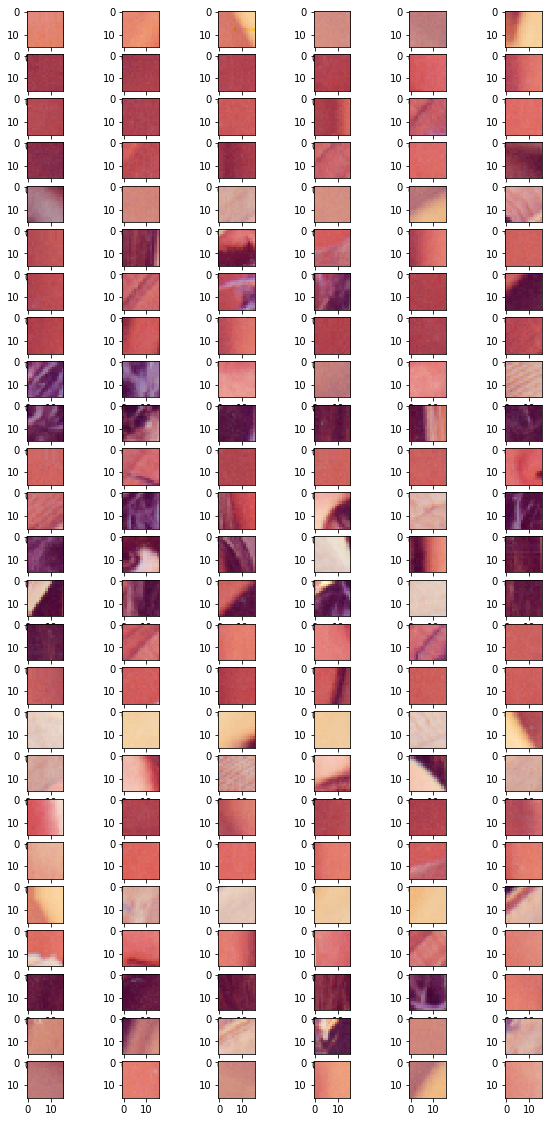

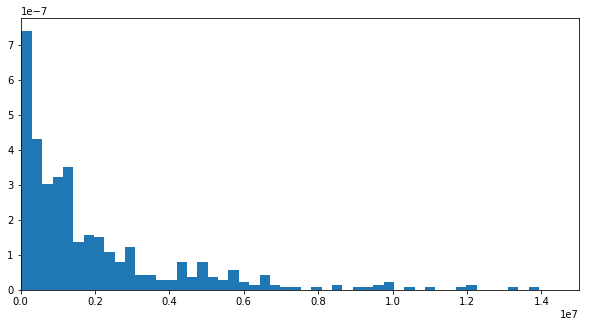

Model 16_3conv3mp_4.2_sigmoid noise = 30 -- mean 1947430.4 -- std 2313113.8
--- Noise level 40 ---
Calculating the SSDs of noisy (noise level = 40) patches descriptors (desc = 16_3conv3mp_4.2_sigmoid)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


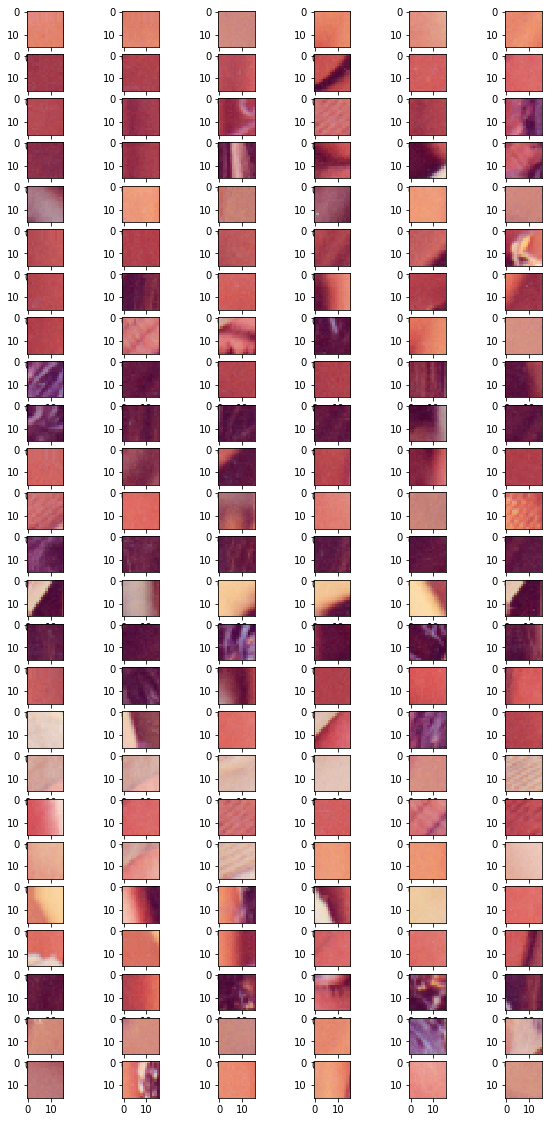

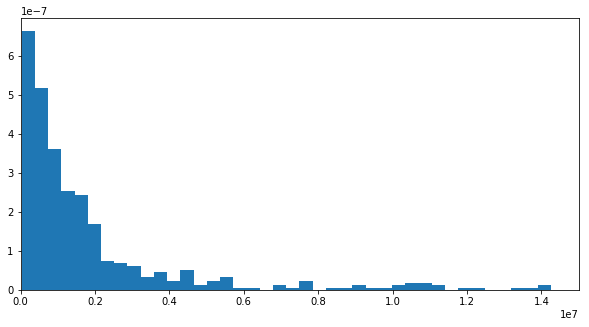

Model 16_3conv3mp_4.2_sigmoid noise = 40 -- mean 1856972.5 -- std 2639258.8
--- Noise level 50 ---
Calculating the SSDs of noisy (noise level = 50) patches descriptors (desc = 16_3conv3mp_4.2_sigmoid)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


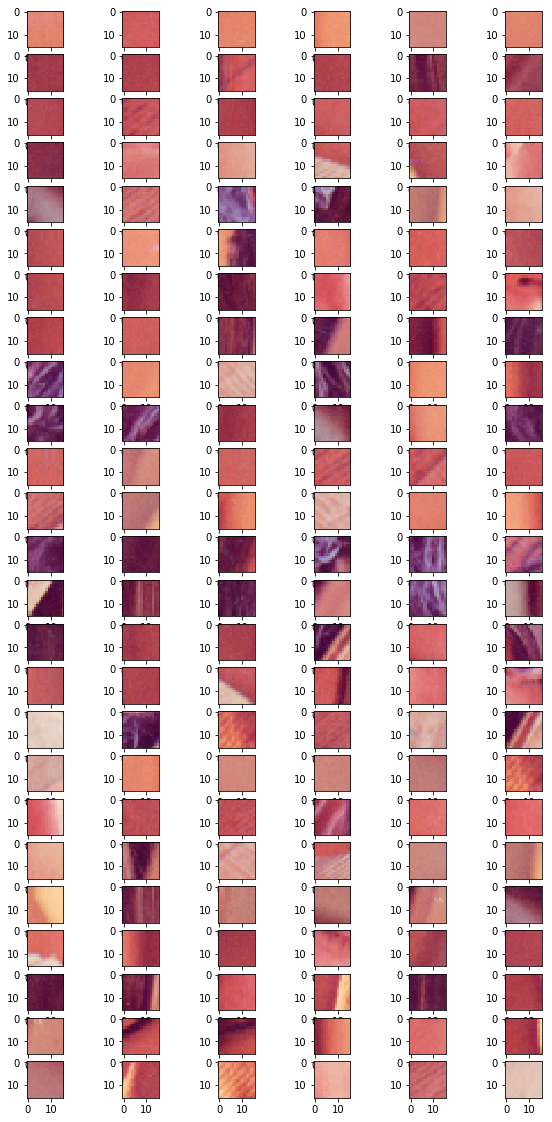

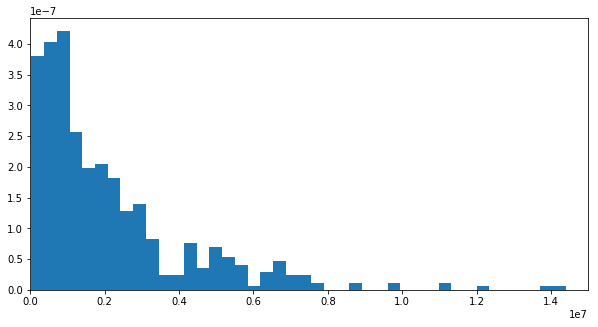

Model 16_3conv3mp_4.2_sigmoid noise = 50 -- mean 2179934.8 -- std 2349216.5


In [160]:
for model_version in model_versions:
    print('***** Evaluating model ' + model_version + ' *****')
    
    means = []
    stds = []
    
    for noise_level in noise_levels:
        
        print('--- Noise level '+ str(noise_level) + ' ---')

        ssds = calculate_SSDs_noisy_desc(noise_level=noise_level, model_version=model_version)
        mean = np.mean(ssds)
        std = np.std(ssds)
        
        means.append(mean)
        stds.append(std)
        
        print('Model ' + model_version + ' noise = ' + str(noise_level).zfill(2) + ' -- mean ' + str(mean) + ' -- std ' + str(std))

***** Evaluating model 16_3conv3mp_2.7 *****
--- Noise level 0 ---
Model 16_3conv3mp_2.7 noise = 00 -- mean 1140909.6 -- std 1956398.2
--- Noise level 10 ---
Model 16_3conv3mp_2.7 noise = 10 -- mean 1242115.8 -- std 2159216.0
--- Noise level 20 ---
Model 16_3conv3mp_2.7 noise = 20 -- mean 1422088.9 -- std 2115656.0
--- Noise level 30 ---
Model 16_3conv3mp_2.7 noise = 30 -- mean 1460749.6 -- std 1869178.2
--- Noise level 40 ---
Model 16_3conv3mp_2.7 noise = 40 -- mean 1462010.9 -- std 1661722.4
--- Noise level 50 ---
Model 16_3conv3mp_2.7 noise = 50 -- mean 1580826.9 -- std 1698315.1
***** Evaluating model 16_3conv3mp_4.0 *****
--- Noise level 0 ---


/home/niaki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/utils/conv_utils.py:82: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


Model 16_3conv3mp_4.0 noise = 00 -- mean 997367.44 -- std 1383109.4
--- Noise level 10 ---
Model 16_3conv3mp_4.0 noise = 10 -- mean 1140461.2 -- std 1564453.4
--- Noise level 20 ---
Model 16_3conv3mp_4.0 noise = 20 -- mean 1534437.9 -- std 2150331.8
--- Noise level 30 ---
Model 16_3conv3mp_4.0 noise = 30 -- mean 1743465.0 -- std 1943471.8
--- Noise level 40 ---
Model 16_3conv3mp_4.0 noise = 40 -- mean 1823850.8 -- std 1992789.1
--- Noise level 50 ---
Model 16_3conv3mp_4.0 noise = 50 -- mean 2164481.2 -- std 2190610.5
***** Evaluating model 16_3conv3mp_4.1 *****
--- Noise level 0 ---
Model 16_3conv3mp_4.1 noise = 00 -- mean 1179964.1 -- std 1610148.9
--- Noise level 10 ---
Model 16_3conv3mp_4.1 noise = 10 -- mean 1441013.2 -- std 1652229.2
--- Noise level 20 ---
Model 16_3conv3mp_4.1 noise = 20 -- mean 1745779.8 -- std 1890335.9
--- Noise level 30 ---
Model 16_3conv3mp_4.1 noise = 30 -- mean 2008065.5 -- std 2119731.2
--- Noise level 40 ---
Model 16_3conv3mp_4.1 noise = 40 -- mean 21324

/home/niaki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model 16_alex_layer1finetuned_2_finetuned_3conv3mp noise = 00 -- mean 497932.6 -- std 929454.25
--- Noise level 10 ---
Model 16_alex_layer1finetuned_2_finetuned_3conv3mp noise = 10 -- mean 517826.53 -- std 962376.0
--- Noise level 20 ---
Model 16_alex_layer1finetuned_2_finetuned_3conv3mp noise = 20 -- mean 505079.16 -- std 841213.7
--- Noise level 30 ---
Model 16_alex_layer1finetuned_2_finetuned_3conv3mp noise = 30 -- mean 560357.7 -- std 1014743.7
--- Noise level 40 ---
Model 16_alex_layer1finetuned_2_finetuned_3conv3mp noise = 40 -- mean 591614.5 -- std 879815.25
--- Noise level 50 ---
Model 16_alex_layer1finetuned_2_finetuned_3conv3mp noise = 50 -- mean 696474.44 -- std 1250813.5


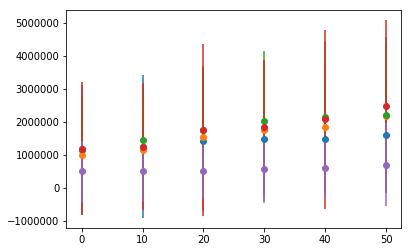

In [172]:
means_for_model = {}
stds_for_model = {}

for model_version in model_versions:
    print('***** Evaluating model ' + model_version + ' *****')
    
    means = []
    stds = []
    
    for noise_level in noise_levels:
        
        print('--- Noise level '+ str(noise_level) + ' ---')

        ssds = calculate_SSDs_noisy_desc_no_output(noise_level=noise_level, model_version=model_version)
        mean = np.mean(ssds)
        std = np.std(ssds)
        
        means.append(mean)
        stds.append(std)
        
        print('Model ' + model_version + ' noise = ' + str(noise_level).zfill(2) + ' -- mean ' + str(mean) + ' -- std ' + str(std))
    
    means_for_model[model_version] = means
    stds_for_model[model_version] = stds
    
    plt.errorbar(noise_levels, means, stds, linestyle='None', marker='o')

***** Evaluating model 16_3conv3mp_2.7 *****
***** Evaluating model 16_3conv3mp_4.0 *****
***** Evaluating model 16_3conv3mp_4.1 *****
***** Evaluating model 16_3conv3mp_4.2_sigmoid *****
***** Evaluating model 16_alex_layer1finetuned_2_finetuned_3conv3mp *****


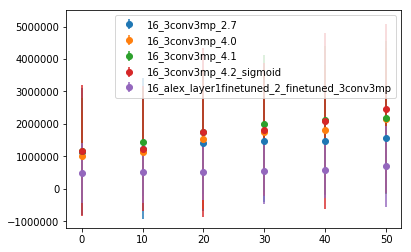

In [192]:
for model_version in model_versions:
    print('***** Evaluating model ' + model_version + ' *****')
    plt.errorbar(noise_levels, means_for_model[model_version], stds_for_model[model_version], linestyle='None', marker='o', label=model_version)
    plt.legend()
    plt.ylim(-1200000, 5500000)
plt.savefig("/home/niaki/Downloads/SSDs_mean_std_by_noise_lvl_all.jpg", bbox_inches='tight')
plt.show()

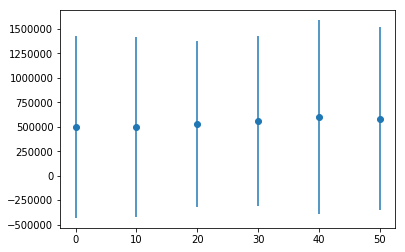

In [169]:
plt.errorbar(noise_levels, means, stds, linestyle='None', marker='o')
plt.show()

In [56]:
input_size = 16 * 16 *3
hidden_size = 128

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# theta = np.load('/home/niaki/temp/encoderChenEtAl_RGB.npy')

# W1 = theta[0:hidden_size * input_size].reshape(hidden_size, input_size)
# W2 = theta[hidden_size * input_size:2 * hidden_size * input_size].reshape(input_size, hidden_size)
# b1 = theta[2 * hidden_size * input_size:2 * hidden_size * input_size + hidden_size]
# b2 = theta[2 * hidden_size * input_size + hidden_size:]

In [88]:
def calculate_SSDs_noisy_desc_otherAE(noise_level, model_version):

    image_noisy = add_gaussian_noise(image, sigma=noise_level)
    base_dir = '/home/niaki/temp'
    theta = np.load(base_dir + '/encoder' + model_version + '.npy')
    
    W1 = theta[0:hidden_size * input_size].reshape(hidden_size, input_size)
    W2 = theta[hidden_size * input_size:2 * hidden_size * input_size].reshape(input_size, hidden_size)
    b1 = theta[2 * hidden_size * input_size:2 * hidden_size * input_size + hidden_size]
    b2 = theta[2 * hidden_size * input_size + hidden_size:]
    
    print('Calculating the SSDs of noisy (noise level = ' + str(noise_level) + ') patches descriptors (desc = ' + model_version + ')...')
    
    query_x_coords = []
    query_y_coords = []

    results_noisy_descr_patches_diffs = {}
    results_noisy_descr_patches_x_coords = {}
    results_noisy_descr_patches_y_coords = {}
    results_noisy_descr_patches_positions = {}

    counter_query_patches = 0

    # just for the sake of output
    total_nr_query_patches = len(range(0, image_width - patch_size + 1, query_stride)) * len(range(0, image_height - patch_size + 1, query_stride))

    for y_query in range(0, image_width - patch_size + 1, query_stride):
        for x_query in range(0, image_height - patch_size + 1, query_stride):
            sys.stdout.write("\r" + str(counter_query_patches + 1) + "/" + str(total_nr_query_patches))

            query_x_coords.append(x_query)
            query_y_coords.append(y_query)   

            query_patch = image_noisy[x_query : x_query + patch_size, y_query : y_query + patch_size, :]
#             query_patch_descr = encoder.predict(np.expand_dims(query_patch, axis=0))[0]
    #         query_patch_descr = np.mean(query_patch)
    
            data = np.expand_dims(query_patch.reshape(patch_size * patch_size * 3), axis=1)
            z2 = W1.dot(data) + np.tile(b1, (1, 1)).transpose()
            query_patch_descr = sigmoid(z2)

            counter_compare_patches = 0
            compare_patches_scores = {}

            patches_diffs = [1000000000]
            patches_x_coords = [-1]
            patches_y_coords = [-1]
            patches_positions = [-1]

            for y_compare in range(0, image_width - patch_size + 1, compare_stride):
                for x_compare in range(0, image_height - patch_size + 1, compare_stride):

                    compare_patch = image_noisy[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :]
#                     compare_patch_descr = encoder.predict(np.expand_dims(compare_patch, axis=0))[0]
    #                 compare_patch_descr = np.mean(compare_patch)

                    data = np.expand_dims(compare_patch.reshape(patch_size * patch_size * 3), axis=1)
                    z2 = W1.dot(data) + np.tile(b1, (1, 1)).transpose()
                    compare_patch_descr = sigmoid(z2)

                    diff = patch_diff(query_patch_descr, compare_patch_descr)
    #                 diff = (query_patch_descr - compare_patch_descr)**2

                    if diff < eps:
                        counter_compare_patches += 1
                        continue

                    # sorting
                    for i in range(len(patches_diffs)):
                        if diff < patches_diffs[i]:
                            patches_diffs.insert(i, diff)
                            patches_x_coords.insert(i, x_compare)
                            patches_y_coords.insert(i, y_compare)
                            patches_positions.insert(i, counter_compare_patches)
                            break

                    counter_compare_patches += 1

            results_noisy_descr_patches_diffs[counter_query_patches] = patches_diffs[:nearest_patches_nb]
            results_noisy_descr_patches_x_coords[counter_query_patches] = patches_x_coords[:nearest_patches_nb]
            results_noisy_descr_patches_y_coords[counter_query_patches] = patches_y_coords[:nearest_patches_nb]
            results_noisy_descr_patches_positions[counter_query_patches] = patches_positions[:nearest_patches_nb]

            counter_query_patches += 1
            
    print()

    print('Visualising the query and similar patches...')
    
    fig = plt.figure(figsize=(10, 20))

#     nr_similar_patches = 5

    columns = nr_similar_patches + 1
    rows = total_nr_query_patches

    counter_query_patches = 0
    for y_query in range(0, image_width - patch_size + 1, query_stride):
        for x_query in range(0, image_height - patch_size + 1, query_stride):
    #         print('query patch')

    #         print(counter_query_patches * (nr_similar_patches + 1) + 1)
            fig.add_subplot(rows, columns, counter_query_patches * (nr_similar_patches + 1) + 1)
            plt.imshow(image[x_query : x_query + patch_size, y_query : y_query + patch_size, :])

    #         print('similar patches (sorted)')

            for i in range(nr_similar_patches):
                x_compare = results_noisy_descr_patches_x_coords[counter_query_patches][i]
                y_compare = results_noisy_descr_patches_y_coords[counter_query_patches][i]

    #             print(counter_query_patches * (nr_similar_patches + 1) + 2 + i)
                fig.add_subplot(rows, columns, counter_query_patches * (nr_similar_patches + 1) + 2 + i)
                plt.imshow(image[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :])

    #         print()
            counter_query_patches += 1


    print('Calculating SSDs of the ground truth patches...')
    
    ssds = []

#     nr_similar_patches = 20

    for q_it in range(total_nr_query_patches):
        for c_it in range(nr_similar_patches):

            # getting the query patch from the clean image
            x_query = query_x_coords[q_it]
            y_query = query_y_coords[q_it]
            query_patch = image[x_query : x_query + patch_size, y_query : y_query + patch_size, :]

            # getting the compare patch from the clean image
            x_compare = results_noisy_descr_patches_x_coords[q_it][c_it]
            y_compare = results_noisy_descr_patches_y_coords[q_it][c_it]
            compare_patch = image[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :]

            # calculating the difference in the clean image
            actual_diff = patch_diff(query_patch, compare_patch)
            ssds.append(actual_diff)

    ssds = np.array(ssds)
    
    print('Plotting the graph of the SSDs of grount truth patches...')
    
    plt.figure(figsize=(10, 5))
    plt.hist(ssds, 50, normed=1)
    plt.xlim(0, 15000000)
    plt.show()
    
    return ssds

In [89]:
def calculate_SSDs_noisy_desc_no_output_otherAE(noise_level, model_version):

    image_noisy = add_gaussian_noise(image, sigma=noise_level)
    base_dir = '/home/niaki/temp'
    theta = np.load(base_dir + '/encoder' + model_version + '.npy')
    
    W1 = theta[0:hidden_size * input_size].reshape(hidden_size, input_size)
    W2 = theta[hidden_size * input_size:2 * hidden_size * input_size].reshape(input_size, hidden_size)
    b1 = theta[2 * hidden_size * input_size:2 * hidden_size * input_size + hidden_size]
    b2 = theta[2 * hidden_size * input_size + hidden_size:]

    query_x_coords = []
    query_y_coords = []

    results_noisy_descr_patches_diffs = {}
    results_noisy_descr_patches_x_coords = {}
    results_noisy_descr_patches_y_coords = {}
    results_noisy_descr_patches_positions = {}

    counter_query_patches = 0

    # just for the sake of output
    total_nr_query_patches = len(range(0, image_width - patch_size + 1, query_stride)) * len(range(0, image_height - patch_size + 1, query_stride))

    for y_query in range(0, image_width - patch_size + 1, query_stride):
        for x_query in range(0, image_height - patch_size + 1, query_stride):
#             sys.stdout.write("\r" + str(counter_query_patches + 1) + "/" + str(total_nr_query_patches))

            query_x_coords.append(x_query)
            query_y_coords.append(y_query)   

            query_patch = image_noisy[x_query : x_query + patch_size, y_query : y_query + patch_size, :]
#             query_patch_descr = encoder.predict(np.expand_dims(query_patch, axis=0))[0]
    #         query_patch_descr = np.mean(query_patch)
            data = np.expand_dims(query_patch.reshape(patch_size * patch_size * 3), axis=1)
            z2 = W1.dot(data) + np.tile(b1, (1, 1)).transpose()
            query_patch_descr = sigmoid(z2)
    

            counter_compare_patches = 0
            compare_patches_scores = {}

            patches_diffs = [1000000000]
            patches_x_coords = [-1]
            patches_y_coords = [-1]
            patches_positions = [-1]

            for y_compare in range(0, image_width - patch_size + 1, compare_stride):
                for x_compare in range(0, image_height - patch_size + 1, compare_stride):

                    compare_patch = image_noisy[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :]
#                     compare_patch_descr = encoder.predict(np.expand_dims(compare_patch, axis=0))[0]
    #                 compare_patch_descr = np.mean(compare_patch)
                    data = np.expand_dims(compare_patch.reshape(patch_size * patch_size * 3), axis=1)
                    z2 = W1.dot(data) + np.tile(b1, (1, 1)).transpose()
                    compare_patch_descr = sigmoid(z2)    

                    diff = patch_diff(query_patch_descr, compare_patch_descr)
    #                 diff = (query_patch_descr - compare_patch_descr)**2

                    if diff < eps:
                        counter_compare_patches += 1
                        continue

                    # sorting
                    for i in range(len(patches_diffs)):
                        if diff < patches_diffs[i]:
                            patches_diffs.insert(i, diff)
                            patches_x_coords.insert(i, x_compare)
                            patches_y_coords.insert(i, y_compare)
                            patches_positions.insert(i, counter_compare_patches)
                            break

                    counter_compare_patches += 1

            results_noisy_descr_patches_diffs[counter_query_patches] = patches_diffs[:nearest_patches_nb]
            results_noisy_descr_patches_x_coords[counter_query_patches] = patches_x_coords[:nearest_patches_nb]
            results_noisy_descr_patches_y_coords[counter_query_patches] = patches_y_coords[:nearest_patches_nb]
            results_noisy_descr_patches_positions[counter_query_patches] = patches_positions[:nearest_patches_nb]

            counter_query_patches += 1
            
    
        
    ssds = []

#     nr_similar_patches = 1000

    for q_it in range(total_nr_query_patches):
        for c_it in range(nr_similar_patches):

            # getting the query patch from the clean image
            x_query = query_x_coords[q_it]
            y_query = query_y_coords[q_it]
            query_patch = image[x_query : x_query + patch_size, y_query : y_query + patch_size, :]

            # getting the compare patch from the clean image
            x_compare = results_noisy_descr_patches_x_coords[q_it][c_it]
            y_compare = results_noisy_descr_patches_y_coords[q_it][c_it]
            compare_patch = image[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :]

            # calculating the difference in the clean image
            actual_diff = patch_diff(query_patch, compare_patch)
            ssds.append(actual_diff)

    ssds = np.array(ssds)
    
    
    return ssds

In [90]:
def calculate_SSDs_noisy_intensity_no_output_otherAE(noise_level):

    image_noisy = add_gaussian_noise(image, sigma=noise_level)
    
    query_x_coords = []
    query_y_coords = []

    results_noisy_descr_patches_diffs = {}
    results_noisy_descr_patches_x_coords = {}
    results_noisy_descr_patches_y_coords = {}
    results_noisy_descr_patches_positions = {}

    counter_query_patches = 0

    # just for the sake of output
    total_nr_query_patches = len(range(0, image_width - patch_size + 1, query_stride)) * len(range(0, image_height - patch_size + 1, query_stride))

    for y_query in range(0, image_width - patch_size + 1, query_stride):
        for x_query in range(0, image_height - patch_size + 1, query_stride):
#             sys.stdout.write("\r" + str(counter_query_patches + 1) + "/" + str(total_nr_query_patches))

            query_x_coords.append(x_query)
            query_y_coords.append(y_query)   

            query_patch = image_noisy[x_query : x_query + patch_size, y_query : y_query + patch_size, :]
#             query_patch_descr = encoder.predict(np.expand_dims(query_patch, axis=0))[0]
    #         query_patch_descr = np.mean(query_patch)
            

            counter_compare_patches = 0
            compare_patches_scores = {}

            patches_diffs = [1000000000]
            patches_x_coords = [-1]
            patches_y_coords = [-1]
            patches_positions = [-1]

            for y_compare in range(0, image_width - patch_size + 1, compare_stride):
                for x_compare in range(0, image_height - patch_size + 1, compare_stride):

                    compare_patch = image_noisy[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :]
#                     compare_patch_descr = encoder.predict(np.expand_dims(compare_patch, axis=0))[0]
    #                 compare_patch_descr = np.mean(compare_patch)
                    
                    diff = patch_diff(query_patch, compare_patch)
    #                 diff = (query_patch_descr - compare_patch_descr)**2

                    if diff < eps:
                        counter_compare_patches += 1
                        continue

                    # sorting
                    for i in range(len(patches_diffs)):
                        if diff < patches_diffs[i]:
                            patches_diffs.insert(i, diff)
                            patches_x_coords.insert(i, x_compare)
                            patches_y_coords.insert(i, y_compare)
                            patches_positions.insert(i, counter_compare_patches)
                            break

                    counter_compare_patches += 1

            results_noisy_descr_patches_diffs[counter_query_patches] = patches_diffs[:nearest_patches_nb]
            results_noisy_descr_patches_x_coords[counter_query_patches] = patches_x_coords[:nearest_patches_nb]
            results_noisy_descr_patches_y_coords[counter_query_patches] = patches_y_coords[:nearest_patches_nb]
            results_noisy_descr_patches_positions[counter_query_patches] = patches_positions[:nearest_patches_nb]

            counter_query_patches += 1
            
    
        
    ssds = []

#     nr_similar_patches = 1000

    for q_it in range(total_nr_query_patches):
        for c_it in range(nr_similar_patches):

            # getting the query patch from the clean image
            x_query = query_x_coords[q_it]
            y_query = query_y_coords[q_it]
            query_patch = image[x_query : x_query + patch_size, y_query : y_query + patch_size, :]

            # getting the compare patch from the clean image
            x_compare = results_noisy_descr_patches_x_coords[q_it][c_it]
            y_compare = results_noisy_descr_patches_y_coords[q_it][c_it]
            compare_patch = image[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :]

            # calculating the difference in the clean image
            actual_diff = patch_diff(query_patch, compare_patch)
            ssds.append(actual_diff)

    ssds = np.array(ssds)
    
    
    return ssds

***** Evaluating model ChenEtAl_RGB *****
--- Noise level 0 ---
Calculating the SSDs of noisy (noise level = 0) patches descriptors (desc = ChenEtAl_RGB)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


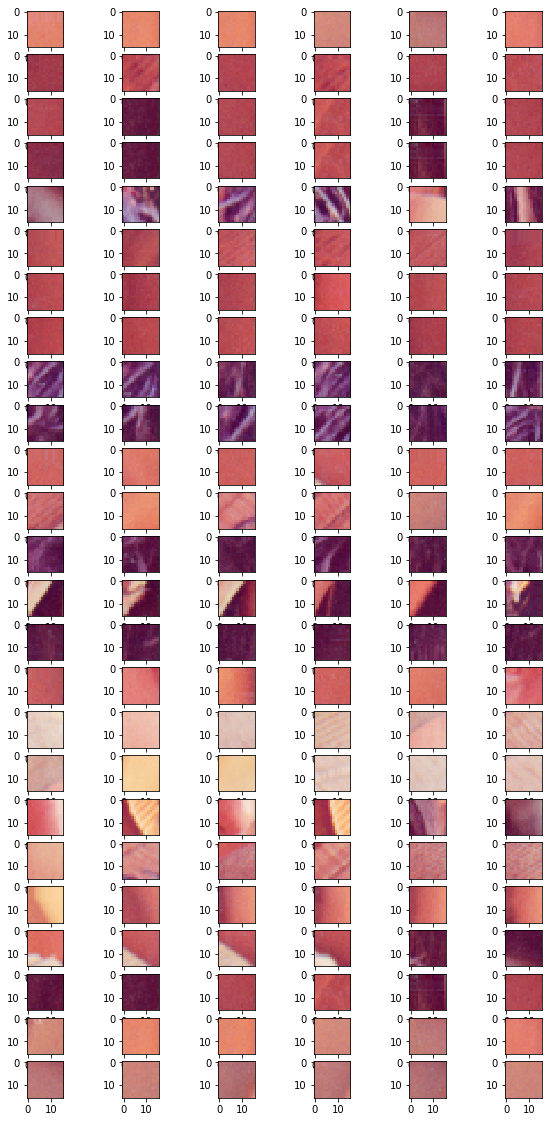

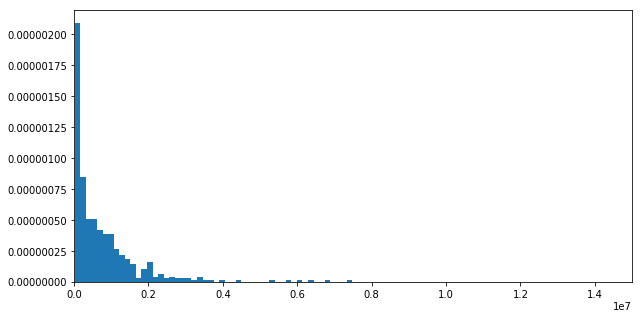

Model ChenEtAl_RGB noise = 00 -- mean 754796.44 -- std 965828.5
--- Noise level 10 ---
Calculating the SSDs of noisy (noise level = 10) patches descriptors (desc = ChenEtAl_RGB)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


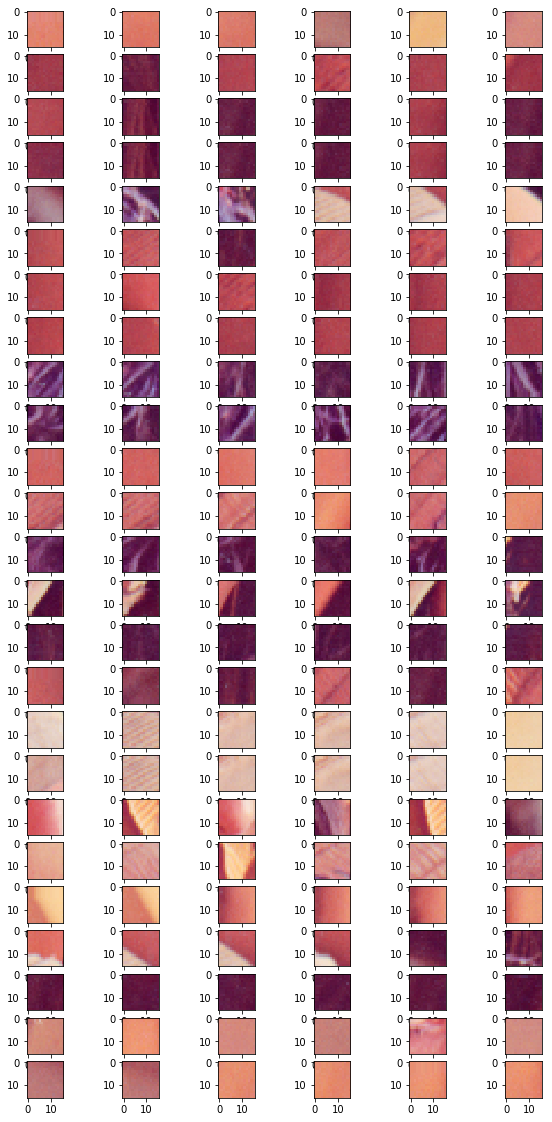

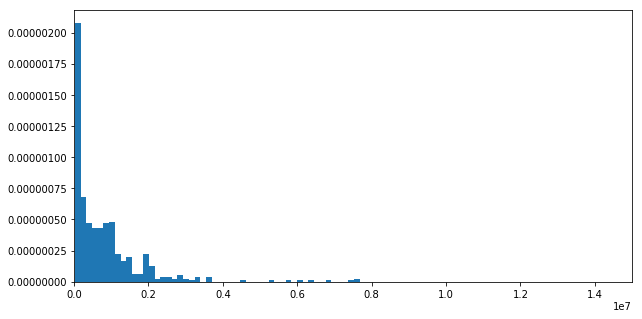

Model ChenEtAl_RGB noise = 10 -- mean 813076.6 -- std 1059729.4
--- Noise level 20 ---
Calculating the SSDs of noisy (noise level = 20) patches descriptors (desc = ChenEtAl_RGB)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


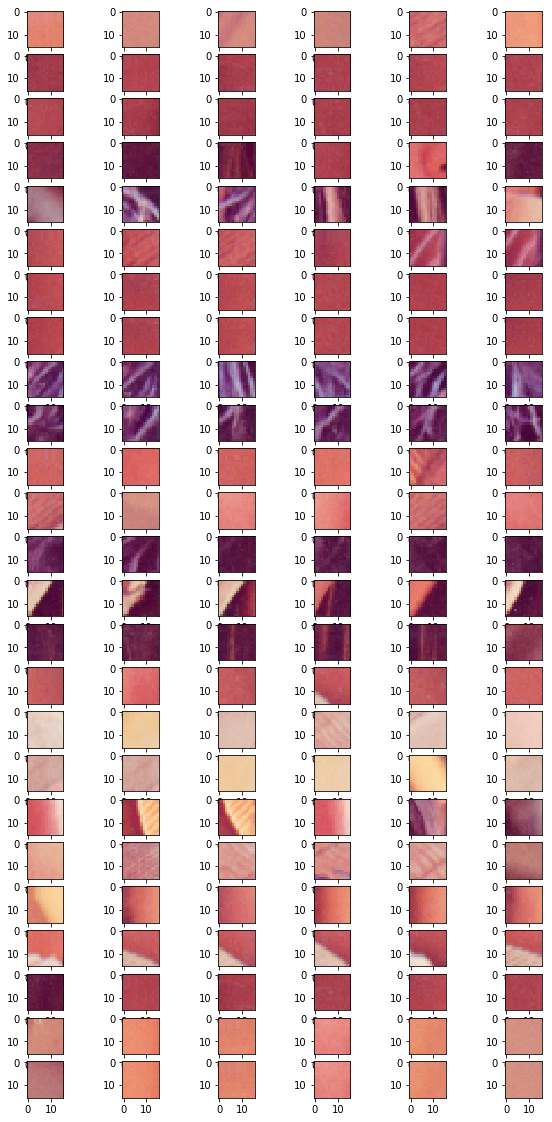

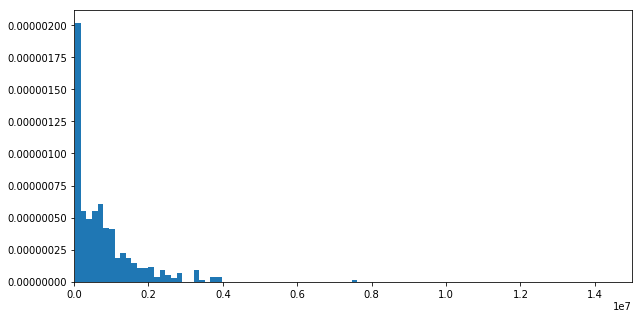

Model ChenEtAl_RGB noise = 20 -- mean 775505.4 -- std 857482.1
--- Noise level 30 ---
Calculating the SSDs of noisy (noise level = 30) patches descriptors (desc = ChenEtAl_RGB)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


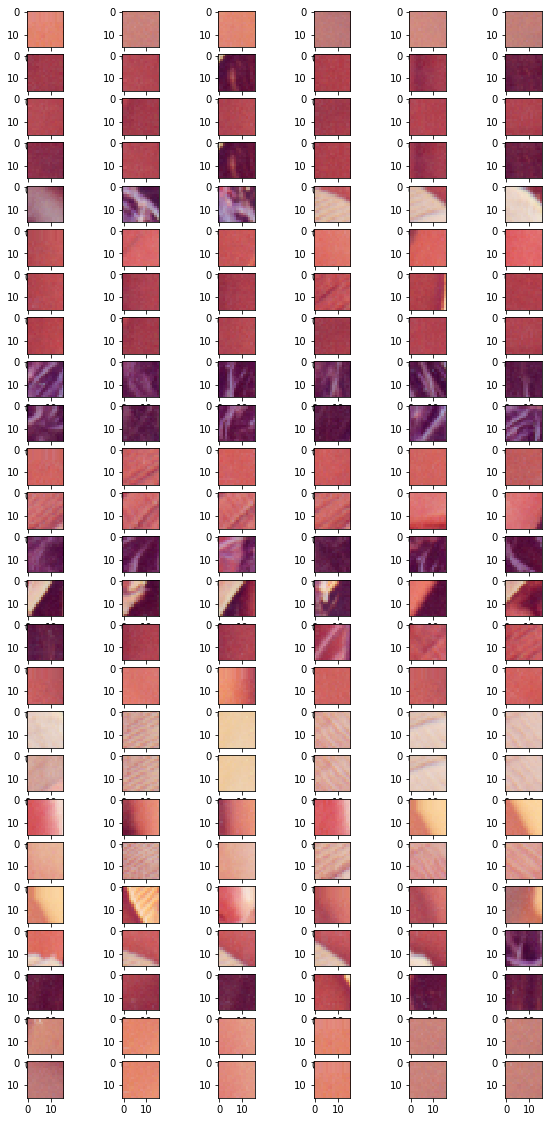

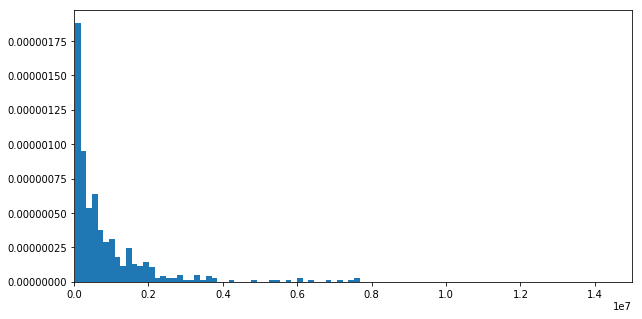

Model ChenEtAl_RGB noise = 30 -- mean 839694.9 -- std 1168892.6
--- Noise level 40 ---
Calculating the SSDs of noisy (noise level = 40) patches descriptors (desc = ChenEtAl_RGB)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


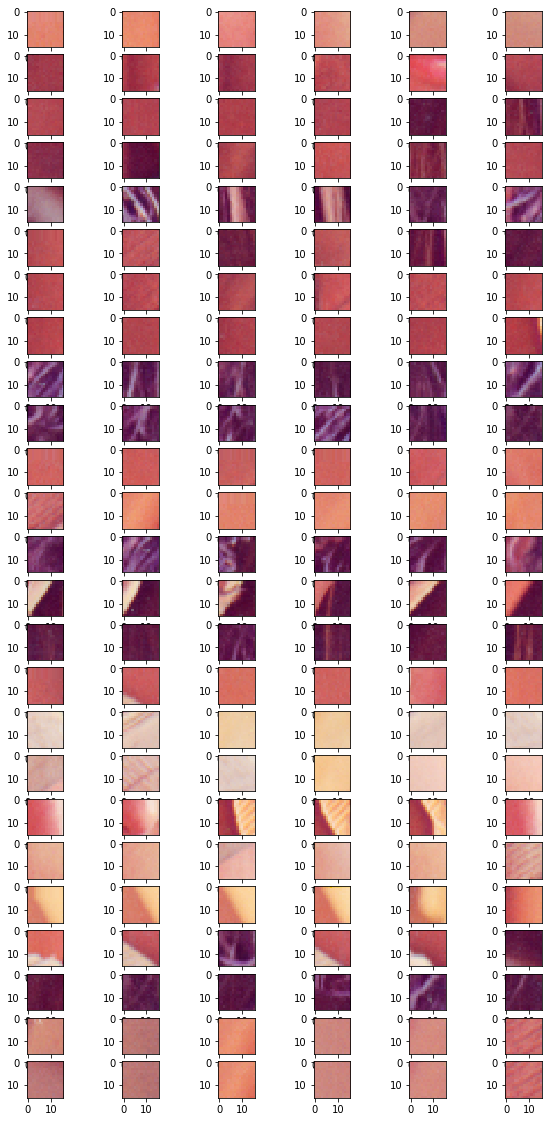

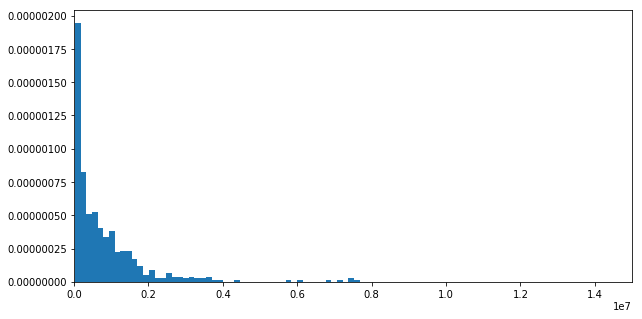

Model ChenEtAl_RGB noise = 40 -- mean 815941.5 -- std 1073605.1
--- Noise level 50 ---
Calculating the SSDs of noisy (noise level = 50) patches descriptors (desc = ChenEtAl_RGB)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


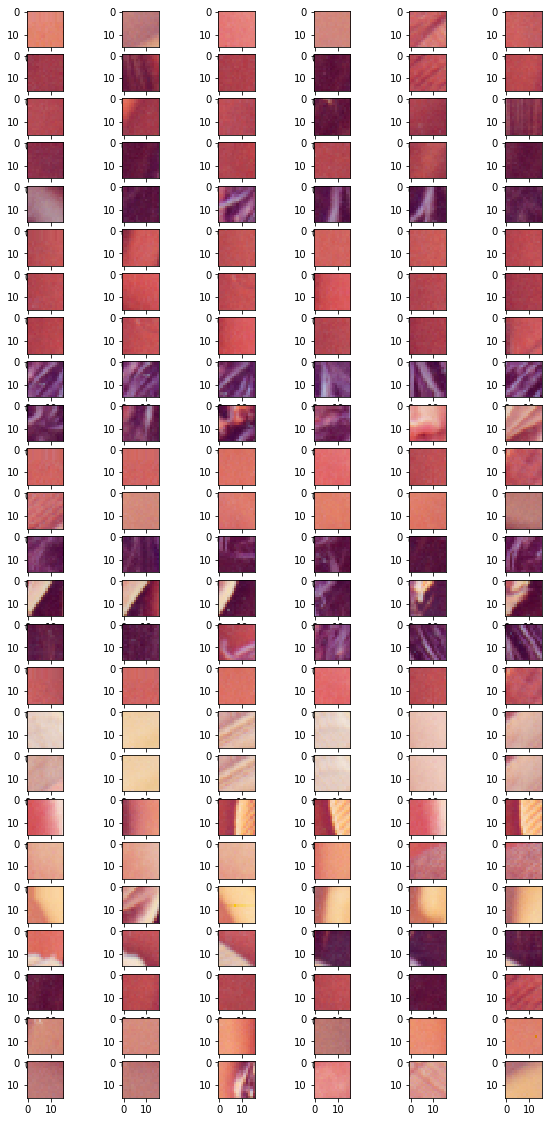

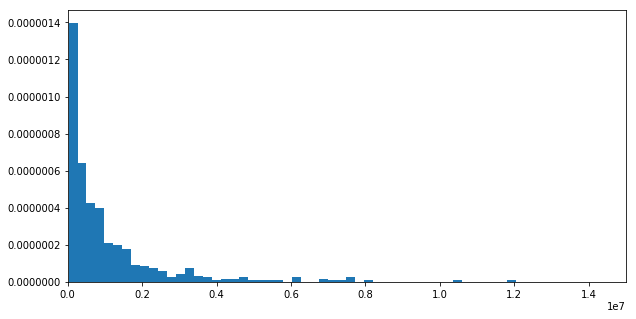

Model ChenEtAl_RGB noise = 50 -- mean 1058059.2 -- std 1510816.2
***** Evaluating model ChenEtAl_RGB_400it *****
--- Noise level 0 ---
Calculating the SSDs of noisy (noise level = 0) patches descriptors (desc = ChenEtAl_RGB_400it)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


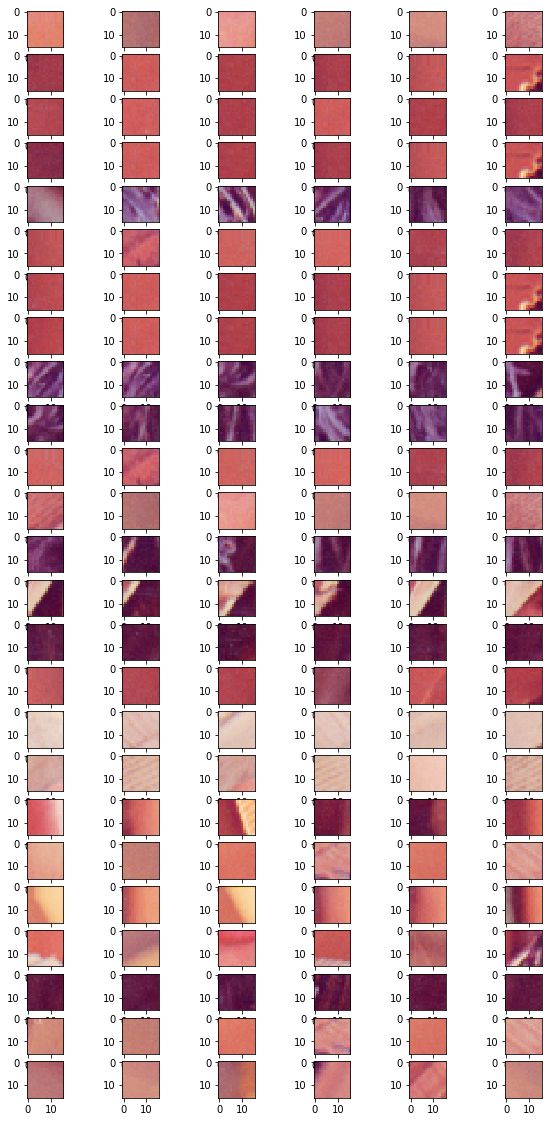

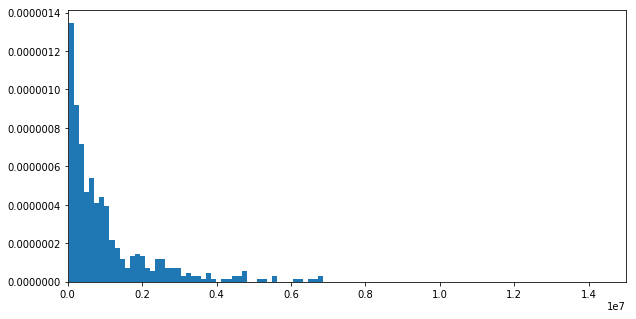

Model ChenEtAl_RGB_400it noise = 00 -- mean 1045793.06 -- std 1223361.4
--- Noise level 10 ---
Calculating the SSDs of noisy (noise level = 10) patches descriptors (desc = ChenEtAl_RGB_400it)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


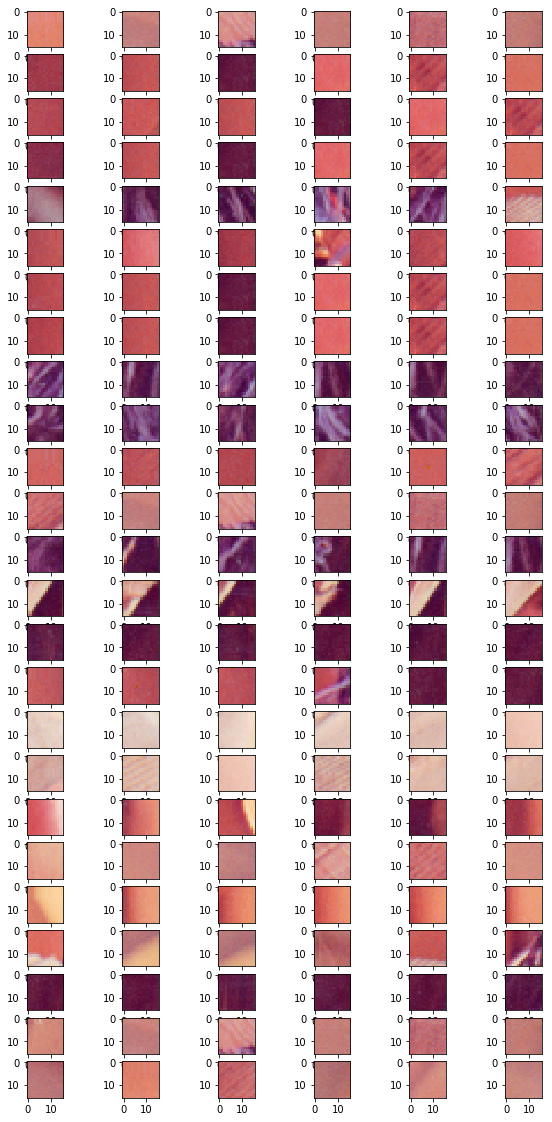

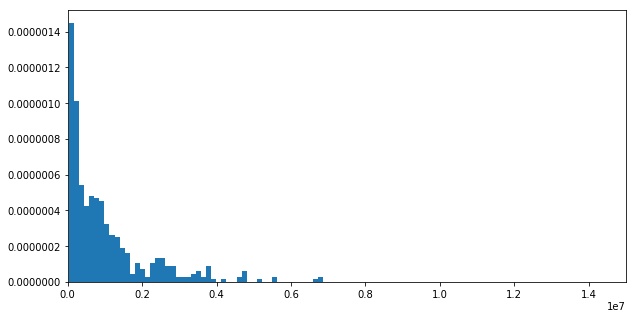

Model ChenEtAl_RGB_400it noise = 10 -- mean 1009671.8 -- std 1145428.6
--- Noise level 20 ---
Calculating the SSDs of noisy (noise level = 20) patches descriptors (desc = ChenEtAl_RGB_400it)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


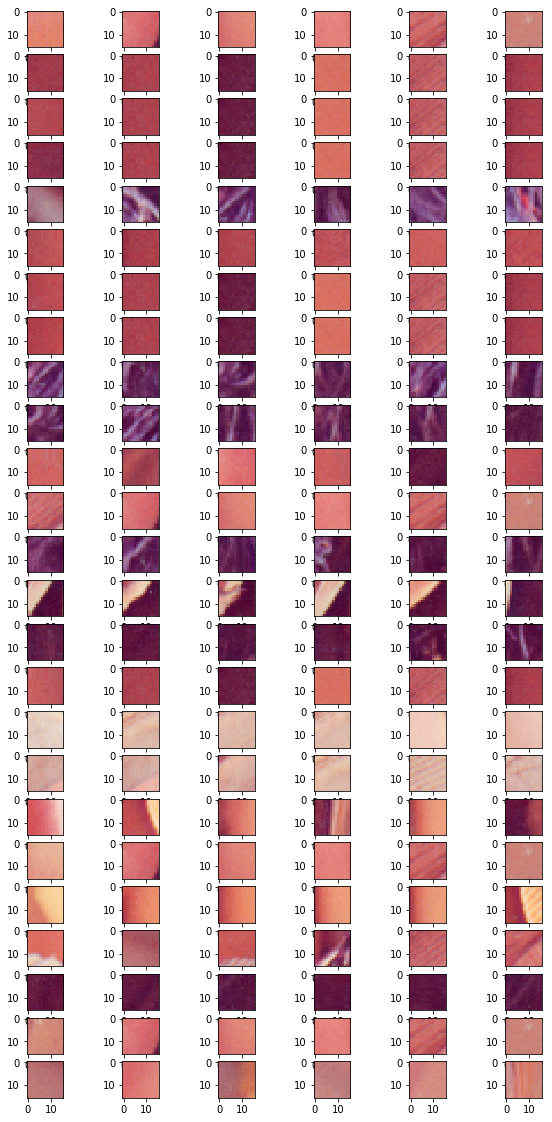

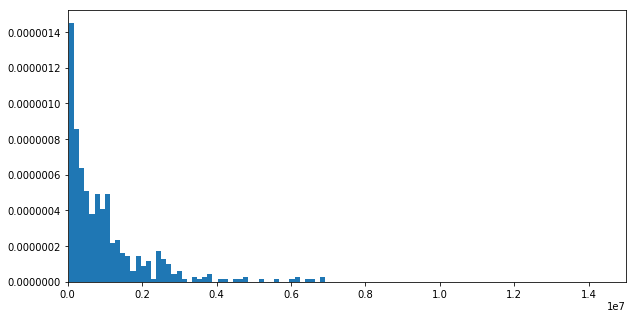

Model ChenEtAl_RGB_400it noise = 20 -- mean 1000396.94 -- std 1154554.2
--- Noise level 30 ---
Calculating the SSDs of noisy (noise level = 30) patches descriptors (desc = ChenEtAl_RGB_400it)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


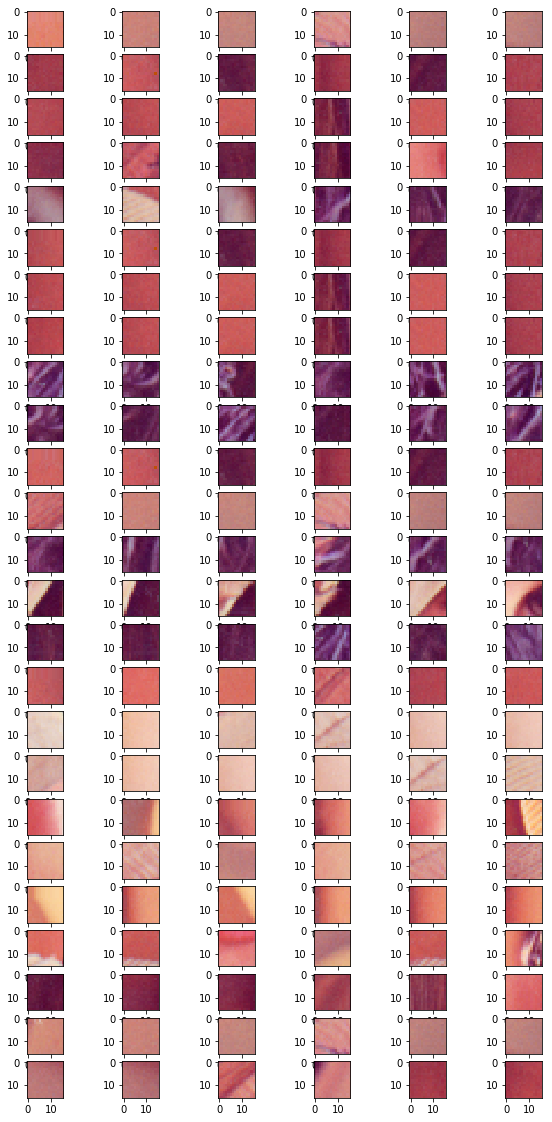

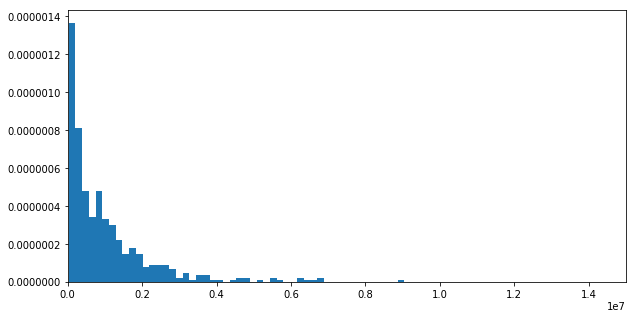

Model ChenEtAl_RGB_400it noise = 30 -- mean 1022226.9 -- std 1220119.4
--- Noise level 40 ---
Calculating the SSDs of noisy (noise level = 40) patches descriptors (desc = ChenEtAl_RGB_400it)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


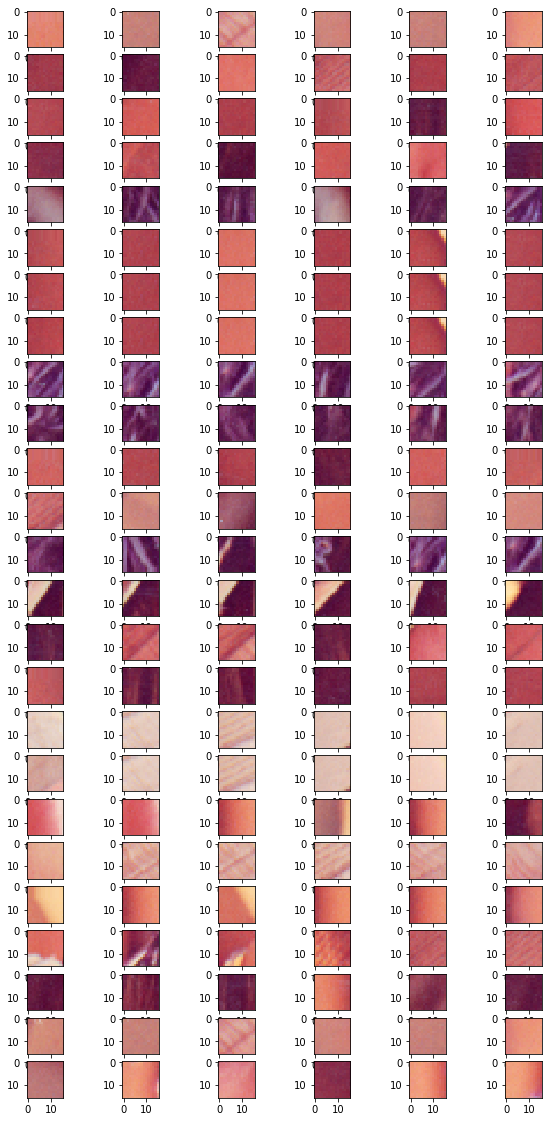

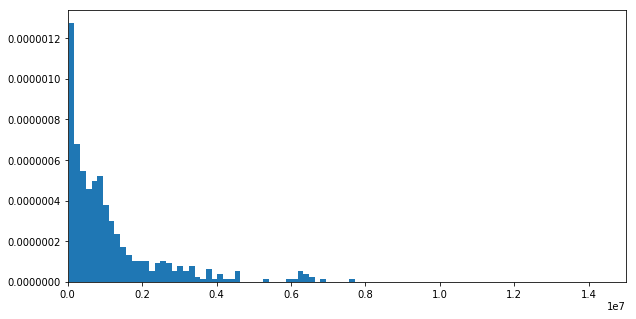

Model ChenEtAl_RGB_400it noise = 40 -- mean 1150242.9 -- std 1331065.6
--- Noise level 50 ---
Calculating the SSDs of noisy (noise level = 50) patches descriptors (desc = ChenEtAl_RGB_400it)...
25/25
Visualising the query and similar patches...
Calculating SSDs of the ground truth patches...
Plotting the graph of the SSDs of grount truth patches...


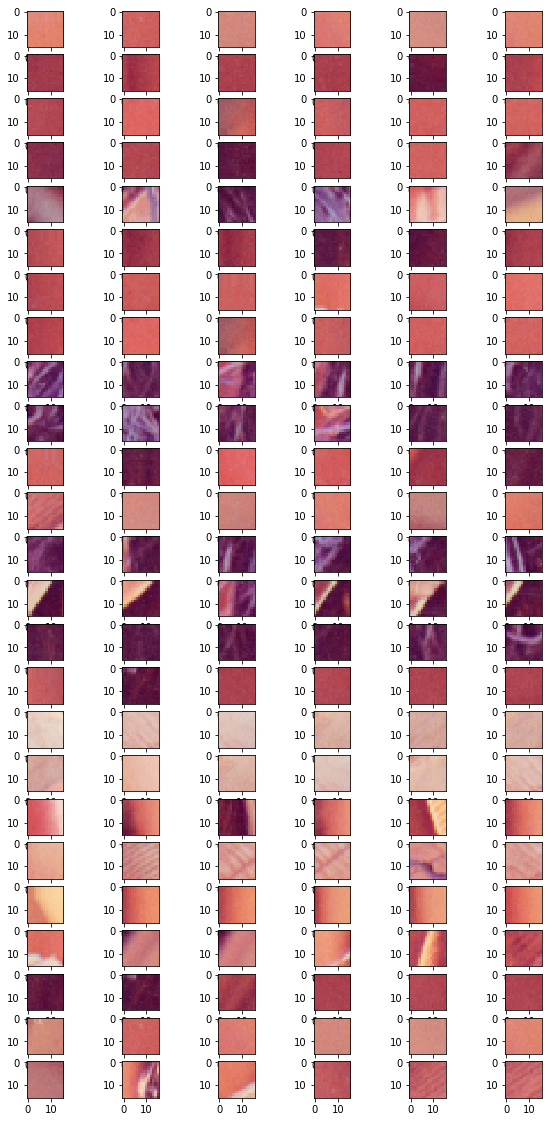

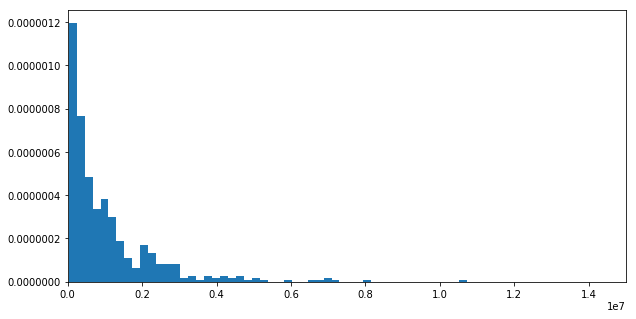

Model ChenEtAl_RGB_400it noise = 50 -- mean 1071023.2 -- std 1306627.5


In [208]:
# Chen et al AE

for model_version in model_versions:
    print('***** Evaluating model ' + model_version + ' *****')
    
    means = []
    stds = []
    
    for noise_level in noise_levels:
        
        print('--- Noise level '+ str(noise_level) + ' ---')

        ssds = calculate_SSDs_noisy_desc_otherAE(noise_level=noise_level, model_version=model_version)
        mean = np.mean(ssds)
        std = np.std(ssds)
        
        means.append(mean)
        stds.append(std)
        
        print('Model ' + model_version + ' noise = ' + str(noise_level).zfill(2) + ' -- mean ' + str(mean) + ' -- std ' + str(std))

***** Evaluating model ChenEtAl_RGB *****
--- Noise level 0 ---
Model ChenEtAl_RGB noise = 00 -- mean 754796.44 -- std 965828.5
--- Noise level 10 ---
Model ChenEtAl_RGB noise = 10 -- mean 783399.4 -- std 1010753.8
--- Noise level 20 ---
Model ChenEtAl_RGB noise = 20 -- mean 887719.06 -- std 1111541.2
--- Noise level 30 ---
Model ChenEtAl_RGB noise = 30 -- mean 840896.94 -- std 1003137.9
--- Noise level 40 ---
Model ChenEtAl_RGB noise = 40 -- mean 954705.1 -- std 1241735.2
--- Noise level 50 ---
Model ChenEtAl_RGB noise = 50 -- mean 1137336.6 -- std 1508724.2
***** Evaluating model ChenEtAl_RGB_400it *****
--- Noise level 0 ---
Model ChenEtAl_RGB_400it noise = 00 -- mean 1045793.06 -- std 1223361.4
--- Noise level 10 ---
Model ChenEtAl_RGB_400it noise = 10 -- mean 956983.06 -- std 1158914.8
--- Noise level 20 ---
Model ChenEtAl_RGB_400it noise = 20 -- mean 1020456.6 -- std 1149953.6
--- Noise level 30 ---
Model ChenEtAl_RGB_400it noise = 30 -- mean 1001728.9 -- std 1145596.5
--- Noise 

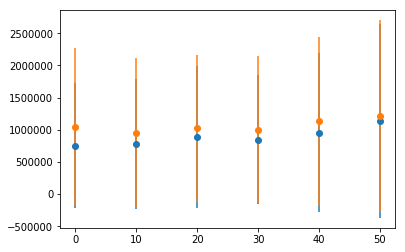

In [210]:
means_for_model_other = {} # to remove in order to get all the results in one dict.
stds_for_model_other = {}  # to remove in order to get all the results in one dict.

for model_version in model_versions:
    print('***** Evaluating model ' + model_version + ' *****')
    
    means = []
    stds = []
    
    for noise_level in noise_levels:
        
        print('--- Noise level '+ str(noise_level) + ' ---')

        ssds = calculate_SSDs_noisy_desc_no_output_otherAE(noise_level=noise_level, model_version=model_version)
        mean = np.mean(ssds)
        std = np.std(ssds)
        
        means.append(mean)
        stds.append(std)
        
        print('Model ' + model_version + ' noise = ' + str(noise_level).zfill(2) + ' -- mean ' + str(mean) + ' -- std ' + str(std))
    
    means_for_model[model_version] = means
    stds_for_model[model_version] = stds
    
    plt.errorbar(noise_levels, means, stds, linestyle='None', marker='o')

In [91]:
model_versions = '16_3conv3mp_2.7', '16_alex_layer1finetuned_2_finetuned_3conv3mp'
# noise_levels = [0, 10, 20, 30, 40, 50, 60, 70]
noise_levels = [0, 25, 50, 75]

In [92]:
ssds_by_model = {}
print('*** nina ***')
for model_version in model_versions:
    ssds_by_model[model_version] = {}
    for noise_level in noise_levels:

        print('--- Noise level '+ str(noise_level) + ' ---')

        ssds_by_model[model_version][noise_level] = calculate_SSDs_noisy_desc_no_output(noise_level=noise_level, model_version='16_alex_layer1finetuned_2_finetuned_3conv3mp')


model_version = 'ChenEtAl_RGB_400it'
ssds_by_model[model_version] = {}
print('*** chen ***')
for noise_level in noise_levels:

    print('--- Noise level '+ str(noise_level) + ' ---')

    ssds_by_model[model_version][noise_level] = calculate_SSDs_noisy_desc_no_output_otherAE(noise_level=noise_level, model_version='ChenEtAl_RGB_400it')

    
model_version = 'intensity'
ssds_by_model[model_version] = {}
print('*** intensity ***')
for noise_level in noise_levels:

    print('--- Noise level '+ str(noise_level) + ' ---')

    ssds_by_model[model_version][noise_level] = calculate_SSDs_noisy_intensity_no_output_otherAE(noise_level=noise_level)

    

*** nina ***
--- Noise level 0 ---


/home/niaki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


--- Noise level 25 ---
--- Noise level 50 ---
--- Noise level 75 ---
--- Noise level 0 ---
--- Noise level 25 ---
--- Noise level 50 ---
--- Noise level 75 ---
*** chen ***
--- Noise level 0 ---
--- Noise level 25 ---
--- Noise level 50 ---
--- Noise level 75 ---
*** intensity ***
--- Noise level 0 ---
--- Noise level 25 ---
--- Noise level 50 ---
--- Noise level 75 ---


/home/niaki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


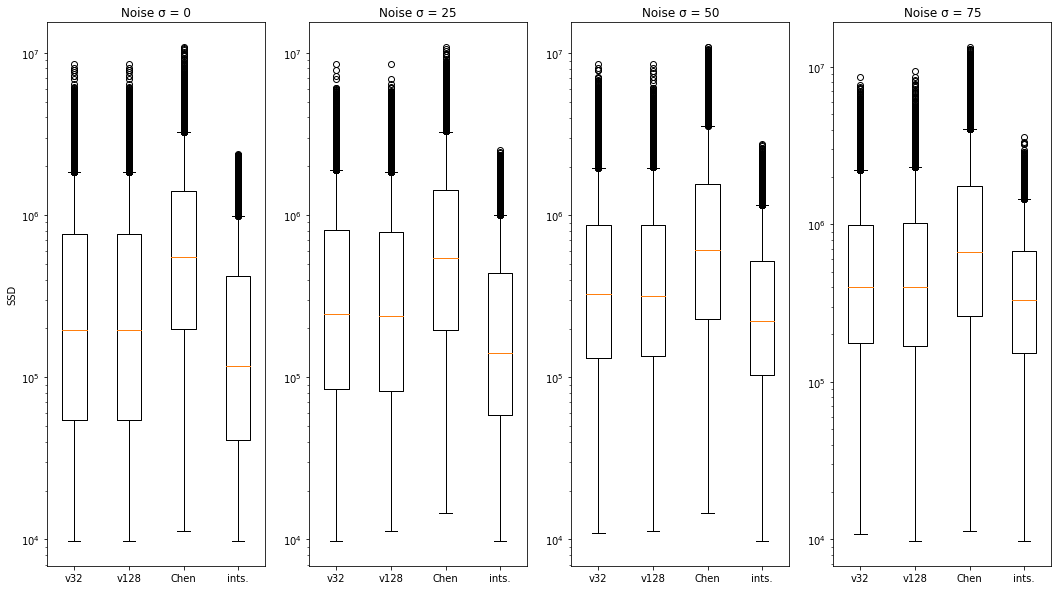

In [107]:
fig = plt.figure(figsize=(18, 10))

for counter, noise_level in enumerate(noise_levels):
    data = []
    labels = []
    data.append(ssds_by_model['16_3conv3mp_2.7'][noise_level])
    data.append(ssds_by_model['16_alex_layer1finetuned_2_finetuned_3conv3mp'][noise_level])
    data.append(ssds_by_model['ChenEtAl_RGB_400it'][noise_level])
    data.append(ssds_by_model['intensity'][noise_level])
    
    labels.append('v32')
    labels.append('v128')
    labels.append('Chen')
    labels.append('ints.')
    ax = fig.add_subplot(1, len(noise_levels), counter + 1)
    if noise_level == 0:
        ax.set_ylabel('SSD')
    ax.set_yscale('log')
    ax.set_title('Noise σ = ' + str(noise_level))
#     ax.set_ylim([0, 18000000])
    ax.boxplot(data, labels=labels)
fig.show()
fig.savefig("/home/niaki/Downloads/SSDs_mean_std_by_noise_lvl_v32_v128_Chen_intensity_boxplot_256queries.pdf", bbox_inches='tight')

In [226]:
model_versions_all = '16_3conv3mp_2.7', '16_3conv3mp_4.0', '16_3conv3mp_4.1','16_3conv3mp_4.2_sigmoid', '16_alex_layer1finetuned_2_finetuned_3conv3mp', 'ChenEtAl_RGB', 'ChenEtAl_RGB_400it'
model_versions_all = '16_alex_layer1finetuned_2_finetuned_3conv3mp', 'ChenEtAl_RGB'

***** Evaluating model 16_alex_layer1finetuned_2_finetuned_3conv3mp *****
***** Evaluating model ChenEtAl_RGB_400it *****


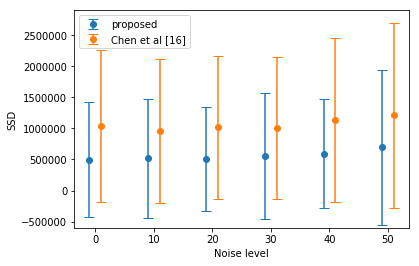

In [308]:
model_version = '16_alex_layer1finetuned_2_finetuned_3conv3mp'
print('***** Evaluating model ' + model_version + ' *****')
plt.errorbar(noise_levels - np.ones(6), means_for_model[model_version], stds_for_model[model_version], linestyle='None', marker='o', label='proposed', capsize=5)
plt.legend()
plt.xlabel('Noise level (σ)')
plt.ylabel('SSD')
plt.ylim(-600000, 2900000)


model_version = '16_3conv3mp_2.7'
print('***** Evaluating model ' + model_version + ' *****')
plt.errorbar(noise_levels - np.ones(6), means_for_model[model_version], stds_for_model[model_version], linestyle='None', marker='o', label='proposed', capsize=5)
plt.legend()
plt.xlabel('Noise level (σ)')
plt.ylabel('SSD')
plt.ylim(-600000, 2900000)


model_version = 'ChenEtAl_RGB_400it'
print('***** Evaluating model ' + model_version + ' *****')
plt.errorbar(noise_levels + np.ones(6), means_for_model[model_version], stds_for_model[model_version], linestyle='None', marker='o', label='Chen et al [16]', capsize=5)
plt.legend()
plt.xlabel('Noise level (σ)')
plt.ylabel('SSD')
plt.ylim(-600000, 2900000)




plt.savefig("/home/niaki/Downloads/SSDs_mean_std_by_noise_lvl_NinaVsChen.pdf", bbox_inches='tight')
plt.show()

In [134]:
image_noisy = add_gaussian_noise(image, sigma=0)

In [135]:
base_dir = '/home/niaki/Code/ImageNet/tiny-imagenet-200'
model_version = '16_3conv3mp_2.7' #'16_3conv3mp_2.7
encoder = load_model(base_dir + '/encoder' + model_version + '.h5')

In [83]:
# todo problem with SSDs in that they are not comparable
# (since my descriptor uses 3 channels, and most of others use 1)
# possible solutions :
#  - train mine on grayscale
#  - use mine on grayscale 
#  - just multiply by 3
#  - 

In [ ]:
'16_3conv3mp_2.7', '16_alex_layer1finetuned_2_finetuned_3conv3mp'

In [46]:
np.median(ssds_by_model['16_alex_layer1finetuned_2_finetuned_3conv3mp'][50])

268216.0

In [41]:
np.median(ssds_by_model['intensity'][50])

218026.5

In [45]:
np.median(ssds_by_model['16_alex_layer1finetuned_2_finetuned_3conv3mp'][50]) - np.median(ssds_by_model['intensity'][50])

50189.5

In [47]:
np.sqrt(50189/(16*16))

14.0018134986151